# Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import random
import os
from glob import glob
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from collections import Counter
import collections
# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading data

In [3]:
final_df = pd.read_csv('Opioid_analytics/Akhila/overdose_prediction/data/3mon_model_final_2007.csv', index_col=False)
final_df.shape
final_df.head()

(67958, 48)

,PATID,PAT_PLANID,INDEX_DT,CHARGE,COPAY,DEDUCT,LOS,STD_COST,ICU_IND,ICU_SURG_IND,...,HEART_REL_PROC_NEG,HEART_REL_PROC_POS,LUNG_REL_PROC,OTHER_PROC_NEG,OTHER_PROC_POS,SPINE_REL_PROC,SUB_REL_PROC,URINARY_REL_PROC,PREV_3MON_OP_HARM,OPIOID_HARM
0,33003283080,53011798434,2007-07-12,25855.00,0.0,0.0,3,28029.15,1,0,...,0,0,0,0,0,0,0,0,0,0
1,33003283085,53011734739,2007-04-12,90365.00,0.0,0.0,27,43013.86,1,0,...,0,0,0,0,0,0,0,0,0,0
2,33003283341,53042726712,2007-07-01,16024.93,0.0,0.0,3,20566.65,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33003283860,53011896577,2007-09-21,3343.46,0.0,750.0,2,15690.06,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33003285138,53049845397,2007-12-03,28078.64,0.0,0.0,3,13671.30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# final_df['OPIOID_HARM'] = final_df['OPIOID_HARM'].astype(str)

# Exploratory Data Analysis

In [5]:
Counter(final_df.OPIOID_HARM)

Counter({0: 67161, 1: 797})

In [6]:
(67161/67958)*100

98.82721681038288

In [7]:
(797/67958)*100

1.1727831896171164

In [8]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67958 entries, 0 to 67957
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PATID                 67958 non-null  int64  
 1   PAT_PLANID            67958 non-null  int64  
 2   INDEX_DT              67958 non-null  object 
 3   CHARGE                67958 non-null  float64
 4   COPAY                 67958 non-null  float64
 5   DEDUCT                67958 non-null  float64
 6   LOS                   67958 non-null  int64  
 7   STD_COST              67958 non-null  float64
 8   ICU_IND               67958 non-null  int64  
 9   ICU_SURG_IND          67958 non-null  int64  
 10  MAJ_SURG_IND          67958 non-null  int64  
 11  MATERNITY_IND         67958 non-null  int64  
 12  GDR_CD                67958 non-null  object 
 13  RACE                  67958 non-null  object 
 14  AGE                   67958 non-null  int64  
 15  ABDOMEN_REL_DIAG_NE

Text(0.5, 1.0, 'Value counts of the target variable')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

([<matplotlib.axis.XTick at 0x7f7217de2b50>,
 [Text(0, 0, 'Non-opioid harm'), Text(1, 0, 'Opioid harm')])

Text(0, 0.5, 'Count')

[Text(0, 0, '67161'), Text(0, 0, '797')]

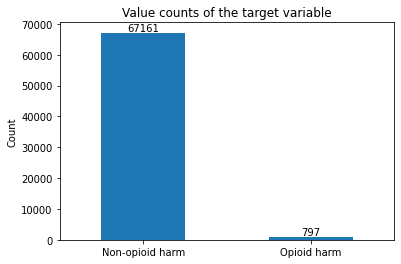

In [9]:
ax=final_df.OPIOID_HARM.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xticks(rotation=0)
# Set the new x-axis labels
plt.xticks([0, 1], ['Non-opioid harm', 'Opioid harm'])
plt.ylabel("Count")
for label in ax.containers:
    ax.bar_label(label)
plt.show()

[Text(0, 0, '12458'),
 Text(0, 0, '14577'),
 Text(0, 0, '9344'),
 Text(0, 0, '8868'),
 Text(0, 0, '6753'),
 Text(0, 0, '5951'),
 Text(0, 0, '3655')]

[Text(0, 0, '91'),
 Text(0, 0, '128'),
 Text(0, 0, '230'),
 Text(0, 0, '165'),
 Text(0, 0, '96'),
 Text(0, 0, '34'),
 Text(0, 0, '12')]

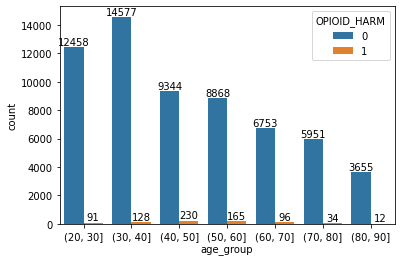

In [10]:
import copy

df = copy.deepcopy(final_df)

# Create age groups
df['age_group'] = pd.cut(df['AGE'], [20, 30, 40, 50, 60, 70, 80, 90])

# Create a count plot of target variable across age groups
ax=sns.countplot(x='age_group', hue='OPIOID_HARM', data=df)
for label in ax.containers:
    ax.bar_label(label)

# Show the plot
plt.show()


In [11]:
num_cols = list(final_df.select_dtypes(include=[np.number]).columns)
num_cols.remove('PATID')
num_cols.remove('PAT_PLANID')
num_cols.remove('CHARGE')
num_cols.remove('COPAY')
num_cols.remove('DEDUCT')

In [12]:
cat_cols = list(final_df.select_dtypes(exclude=[np.number]).columns)
cat_cols.remove('INDEX_DT')

In [13]:
df = final_df[~final_df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.shape

(67958, 48)

In [14]:
df[num_cols].describe()

,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,HEART_REL_PROC_NEG,HEART_REL_PROC_POS,LUNG_REL_PROC,OTHER_PROC_NEG,OTHER_PROC_POS,SPINE_REL_PROC,SUB_REL_PROC,URINARY_REL_PROC,PREV_3MON_OP_HARM,OPIOID_HARM
count,67958.000000,6.795800e+04,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,...,67958.000000,67958.000000,67958.00000,67958.000000,67958.000000,67958.000000,67958.00000,67958.000000,67958.000000,67958.000000
mean,6.498278,2.157012e+04,0.246196,0.095544,0.458357,0.298714,45.068336,0.007593,0.040569,0.081521,...,0.019762,0.053136,0.01598,0.038642,0.044307,0.012478,0.00518,0.016540,0.081359,0.011728
std,16.499716,4.221491e+04,0.511646,0.307760,0.525070,0.487405,20.137554,0.089148,0.221135,0.294161,...,0.177806,0.241796,0.13080,0.195695,0.211351,0.112195,0.07712,0.129259,0.305180,0.107659
min,1.000000,-1.130977e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2.000000,8.372930e+03,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,3.000000,1.249223e+04,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,5.000000,2.056665e+04,0.000000,0.000000,1.000000,1.000000,60.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1399.000000,4.013816e+06,9.000000,5.000000,6.000000,5.000000,90.000000,3.000000,6.000000,7.000000,...,10.000000,5.000000,4.00000,3.000000,4.000000,2.000000,4.00000,4.000000,6.000000,1.000000


In [15]:
# np.percentile(final_df['COPAY'], [80, 85, 90, 93, 95, 97, 99, 100])

# np.percentile(final_df['DEDUCT'], [80, 85, 90, 93, 95, 97, 99, 100])

In [16]:
np.percentile(df['AGE'], [80, 85, 90, 93, 95, 97, 99, 100])

np.percentile(df['LOS'], [80, 85, 90, 93, 95, 97, 99, 100])

np.percentile(df['STD_COST'], [80, 85, 90, 93, 95, 97, 99, 100])

array([64., 69., 76., 78., 81., 84., 88., 90.])

array([   6.,    8.,   12.,   17.,   24.,   36.,   74., 1399.])

array([  24178.5   ,   30209.22  ,   40614.552 ,   52983.8352,
         66998.567 ,   89654.48  ,  167970.0434, 4013816.11  ])

In [17]:
df[df['STD_COST'] < 0].shape

(383, 48)

In [18]:
df['STD_COST'] = np.where(df['STD_COST'] < 0, 0, df['STD_COST'])
df[df['STD_COST'] < 0].shape

df['LOS'] = np.where(df['LOS'] < 0, 0, df['LOS'])
df[df['LOS'] < 0].shape

(0, 48)

(0, 48)

In [19]:
df[df['LOS'] > 49].shape

(1321, 48)

In [20]:
df[df['STD_COST'] > 76889].shape

(2584, 48)

In [21]:
len(num_cols)

40

array([[<AxesSubplot:title={'center':'LOS'}>,
        <AxesSubplot:title={'center':'STD_COST'}>,
        <AxesSubplot:title={'center':'ICU_IND'}>,
        <AxesSubplot:title={'center':'ICU_SURG_IND'}>,
        <AxesSubplot:title={'center':'MAJ_SURG_IND'}>,
        <AxesSubplot:title={'center':'MATERNITY_IND'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'ABDOMEN_REL_DIAG_NEG'}>,
        <AxesSubplot:title={'center':'ABDOMEN_REL_DIAG_POS'}>,
        <AxesSubplot:title={'center':'BLOOD_REL_DIAG'}>,
        <AxesSubplot:title={'center':'HEART_REL_DIAG'}>,
        <AxesSubplot:title={'center':'HX_TOB_HAZ_DIAG'}>],
       [<AxesSubplot:title={'center':'INJURY_REL_DIAG'}>,
        <AxesSubplot:title={'center':'KIDNEY_REL_DIAG'}>,
        <AxesSubplot:title={'center':'LEUK_UNS_DIAG'}>,
        <AxesSubplot:title={'center':'LIVER_REL_DIAG'}>,
        <AxesSubplot:title={'center':'LUNG_REL_DIAG'}>,
        <AxesSubplot:title={'center':'MENTAL_DISORDER_DI

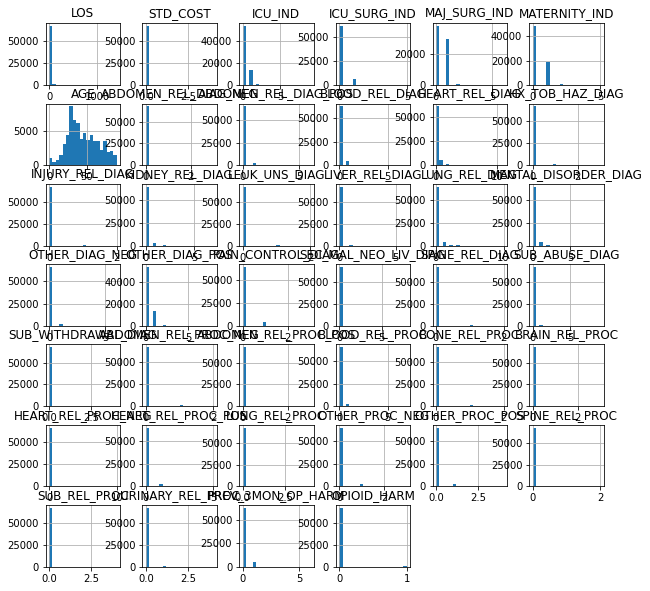

In [22]:
# plot histograms for all numerical columns
df[num_cols].hist(bins=20, figsize=(10, 10))
plt.show()

Text(0.5, 1.0, 'Distribution plot for LOS')

Text(0.5, 6.799999999999997, 'LOS')

Text(-8.824999999999996, 0.5, 'Frequency')

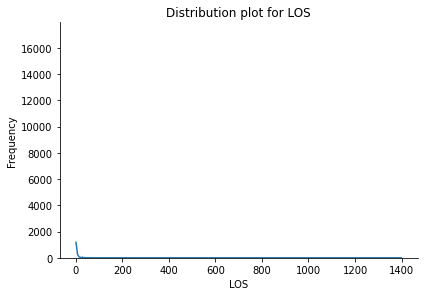

Text(0.5, 1.0, 'Distribution plot for STD_COST')

Text(0.5, 6.799999999999997, 'STD_COST')

Text(-2.4499999999999957, 0.5, 'Frequency')

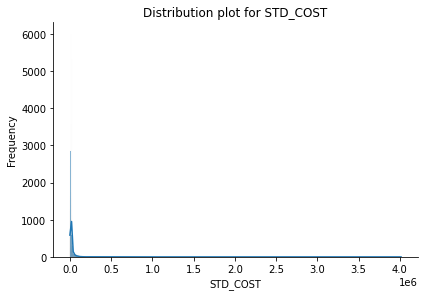

Text(0.5, 1.0, 'Distribution plot for ICU_IND')

Text(0.5, 6.799999999999997, 'ICU_IND')

Text(-15.199999999999996, 0.5, 'Frequency')

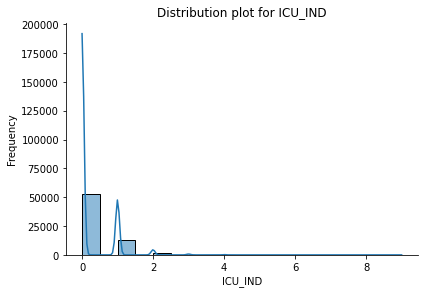

Text(0.5, 1.0, 'Distribution plot for ICU_SURG_IND')

Text(0.5, 6.799999999999997, 'ICU_SURG_IND')

Text(-15.199999999999996, 0.5, 'Frequency')

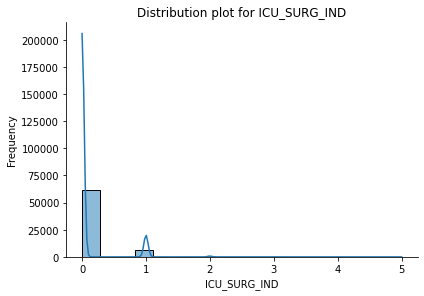

Text(0.5, 1.0, 'Distribution plot for MAJ_SURG_IND')

Text(0.5, 6.799999999999997, 'MAJ_SURG_IND')

Text(-8.824999999999996, 0.5, 'Frequency')

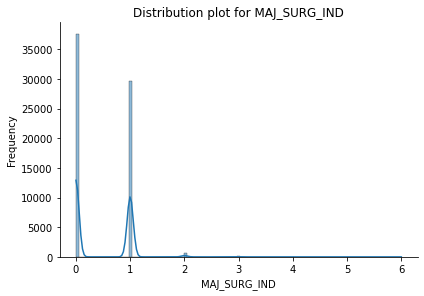

Text(0.5, 1.0, 'Distribution plot for MATERNITY_IND')

Text(0.5, 6.799999999999997, 'MATERNITY_IND')

Text(-8.699999999999996, 0.5, 'Frequency')

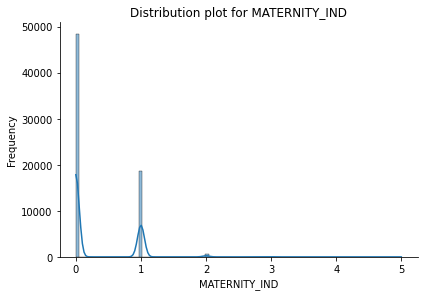

Text(0.5, 1.0, 'Distribution plot for AGE')

Text(0.5, 6.799999999999997, 'AGE')

Text(-2.5749999999999957, 0.5, 'Frequency')

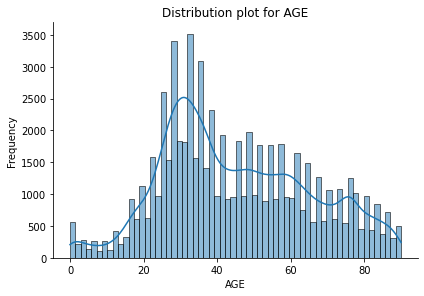

Text(0.5, 1.0, 'Distribution plot for ABDOMEN_REL_DIAG_NEG')

Text(0.5, 6.799999999999997, 'ABDOMEN_REL_DIAG_NEG')

Text(-14.949999999999996, 0.5, 'Frequency')

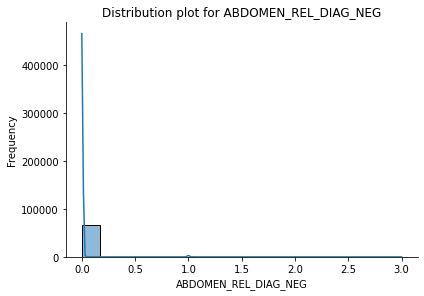

Text(0.5, 1.0, 'Distribution plot for ABDOMEN_REL_DIAG_POS')

Text(0.5, 6.799999999999997, 'ABDOMEN_REL_DIAG_POS')

Text(-15.074999999999996, 0.5, 'Frequency')

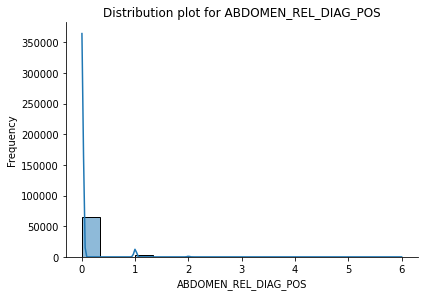

Text(0.5, 1.0, 'Distribution plot for BLOOD_REL_DIAG')

Text(0.5, 6.799999999999997, 'BLOOD_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

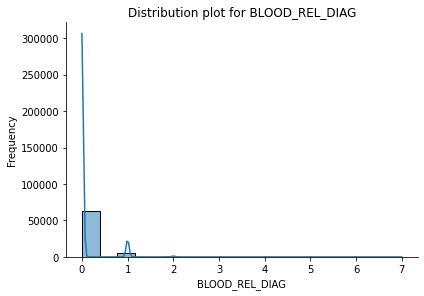

Text(0.5, 1.0, 'Distribution plot for HEART_REL_DIAG')

Text(0.5, 6.799999999999997, 'HEART_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

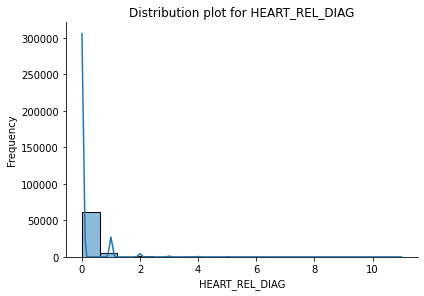

Text(0.5, 1.0, 'Distribution plot for HX_TOB_HAZ_DIAG')

Text(0.5, 6.799999999999997, 'HX_TOB_HAZ_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

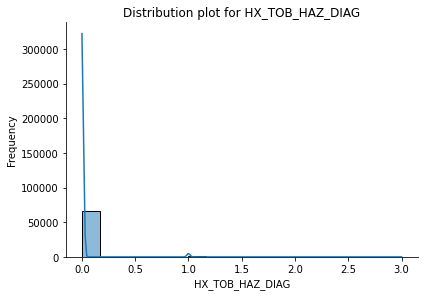

Text(0.5, 1.0, 'Distribution plot for INJURY_REL_DIAG')

Text(0.5, 6.799999999999997, 'INJURY_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

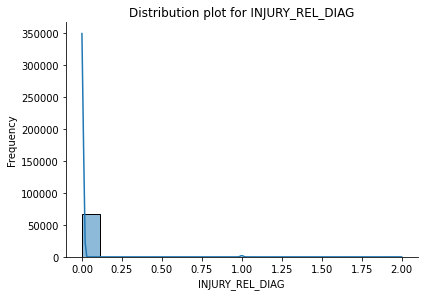

Text(0.5, 1.0, 'Distribution plot for KIDNEY_REL_DIAG')

Text(0.5, 6.799999999999997, 'KIDNEY_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

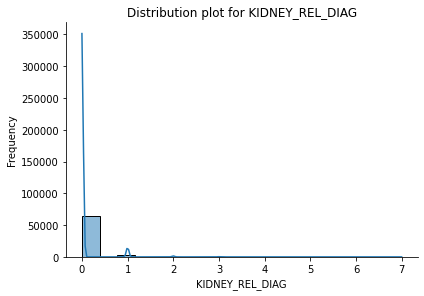

Text(0.5, 1.0, 'Distribution plot for LEUK_UNS_DIAG')

Text(0.5, 6.799999999999997, 'LEUK_UNS_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

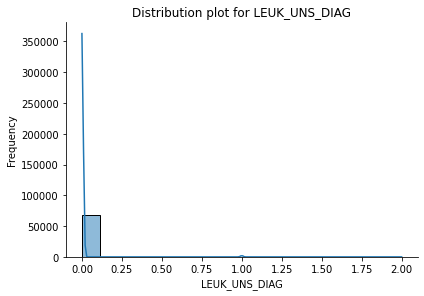

Text(0.5, 1.0, 'Distribution plot for LIVER_REL_DIAG')

Text(0.5, 6.799999999999997, 'LIVER_REL_DIAG')

Text(-14.949999999999996, 0.5, 'Frequency')

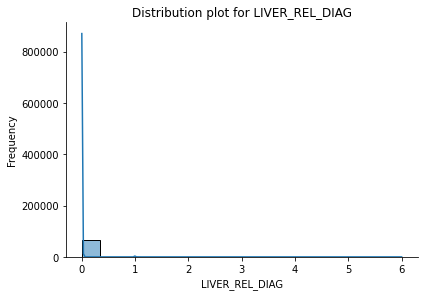

Text(0.5, 1.0, 'Distribution plot for LUNG_REL_DIAG')

Text(0.5, 6.799999999999997, 'LUNG_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

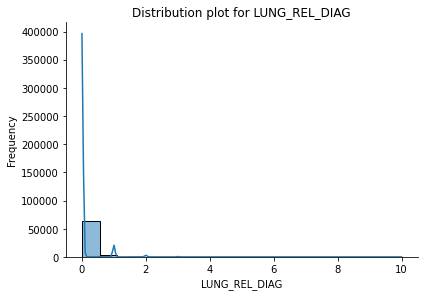

Text(0.5, 1.0, 'Distribution plot for MENTAL_DISORDER_DIAG')

Text(0.5, 6.799999999999997, 'MENTAL_DISORDER_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

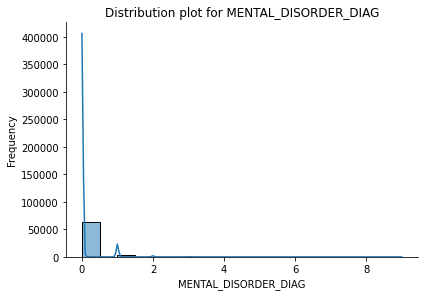

Text(0.5, 1.0, 'Distribution plot for OTHER_DIAG_NEG')

Text(0.5, 6.799999999999997, 'OTHER_DIAG_NEG')

Text(-15.074999999999996, 0.5, 'Frequency')

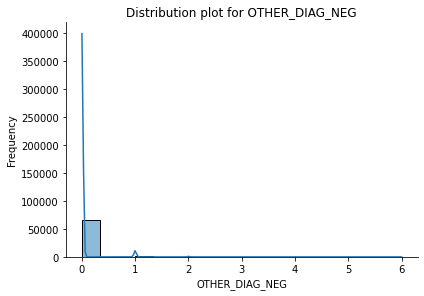

Text(0.5, 1.0, 'Distribution plot for OTHER_DIAG_POS')

Text(0.5, 6.799999999999997, 'OTHER_DIAG_POS')

Text(-15.074999999999996, 0.5, 'Frequency')

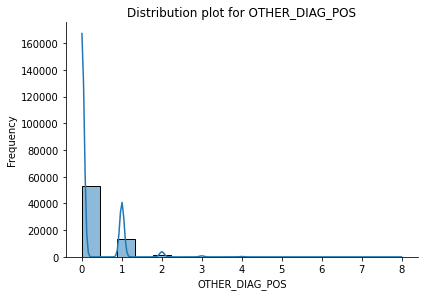

Text(0.5, 1.0, 'Distribution plot for PAIN_CONTROL_DIAG')

Text(0.5, 6.799999999999997, 'PAIN_CONTROL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

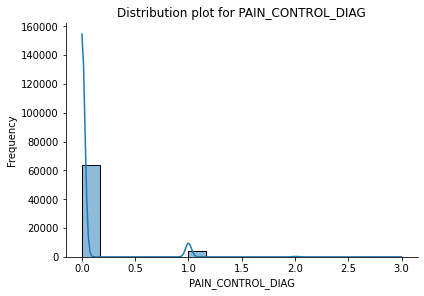

Text(0.5, 1.0, 'Distribution plot for SEC_MAL_NEO_LIV_DIAG')

Text(0.5, 6.799999999999997, 'SEC_MAL_NEO_LIV_DIAG')

Text(6.675000000000004, 0.5, 'Frequency')

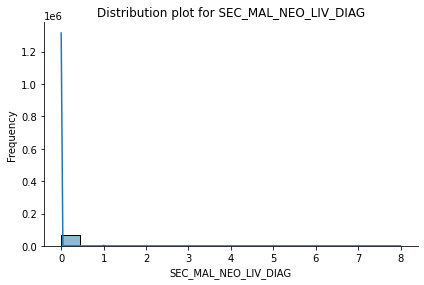

Text(0.5, 1.0, 'Distribution plot for SPINE_REL_DIAG')

Text(0.5, 6.799999999999997, 'SPINE_REL_DIAG')

Text(-15.074999999999996, 0.5, 'Frequency')

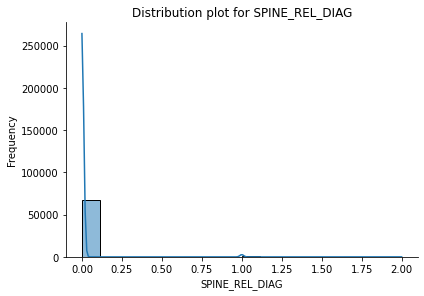

Text(0.5, 1.0, 'Distribution plot for SUB_ABUSE_DIAG')

Text(0.5, 6.799999999999997, 'SUB_ABUSE_DIAG')

Text(-14.949999999999996, 0.5, 'Frequency')

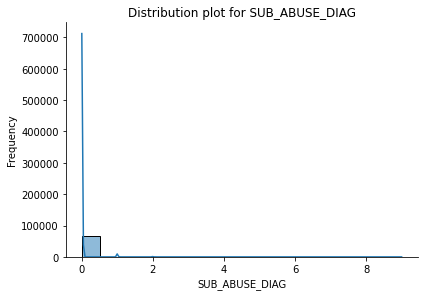

Text(0.5, 1.0, 'Distribution plot for SUB_WITHDRAWAL_DIAG')

Text(0.5, 6.799999999999997, 'SUB_WITHDRAWAL_DIAG')

Text(-14.949999999999996, 0.5, 'Frequency')

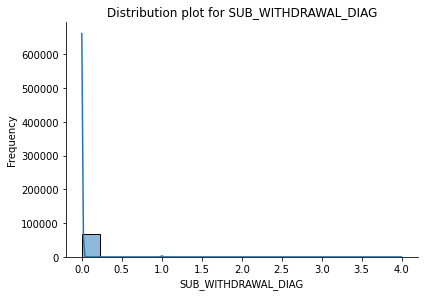

Text(0.5, 1.0, 'Distribution plot for ABDOMEN_REL_PROC_NEG')

Text(0.5, 6.799999999999997, 'ABDOMEN_REL_PROC_NEG')

Text(-15.199999999999996, 0.5, 'Frequency')

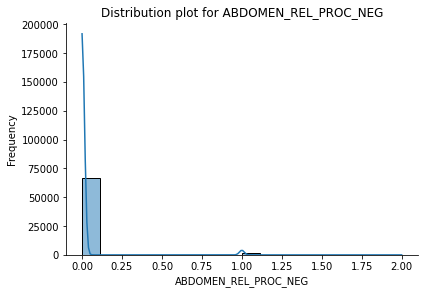

Text(0.5, 1.0, 'Distribution plot for ABDOMEN_REL_PROC_POS')

Text(0.5, 6.799999999999997, 'ABDOMEN_REL_PROC_POS')

Text(-14.949999999999996, 0.5, 'Frequency')

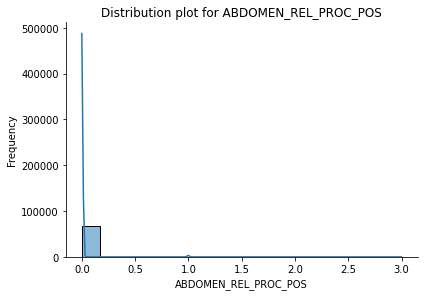

Text(0.5, 1.0, 'Distribution plot for BLOOD_REL_PROC')

Text(0.5, 6.799999999999997, 'BLOOD_REL_PROC')

Text(-15.074999999999996, 0.5, 'Frequency')

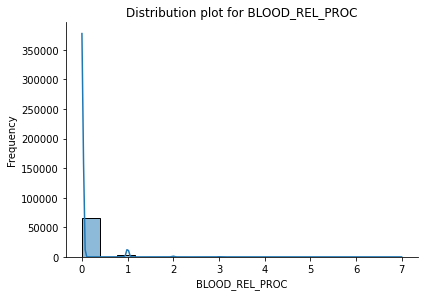

Text(0.5, 1.0, 'Distribution plot for BONE_REL_PROC')

Text(0.5, 6.799999999999997, 'BONE_REL_PROC')

Text(-15.074999999999996, 0.5, 'Frequency')

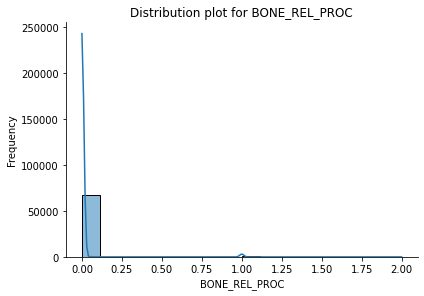

Text(0.5, 1.0, 'Distribution plot for BRAIN_REL_PROC')

Text(0.5, 6.799999999999997, 'BRAIN_REL_PROC')

Text(-14.949999999999996, 0.5, 'Frequency')

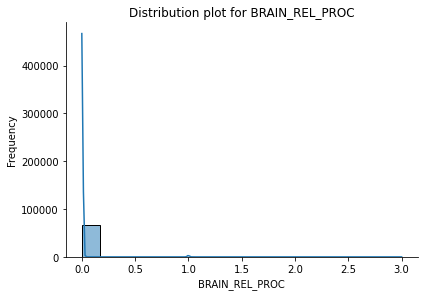

Text(0.5, 1.0, 'Distribution plot for HEART_REL_PROC_NEG')

Text(0.5, 6.799999999999997, 'HEART_REL_PROC_NEG')

Text(-14.949999999999996, 0.5, 'Frequency')

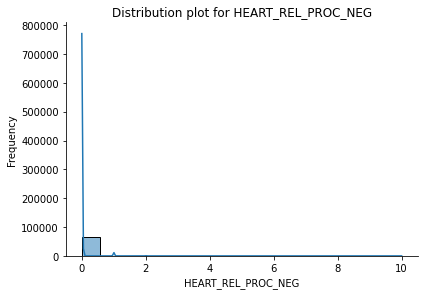

Text(0.5, 1.0, 'Distribution plot for HEART_REL_PROC_POS')

Text(0.5, 6.799999999999997, 'HEART_REL_PROC_POS')

Text(-15.074999999999996, 0.5, 'Frequency')

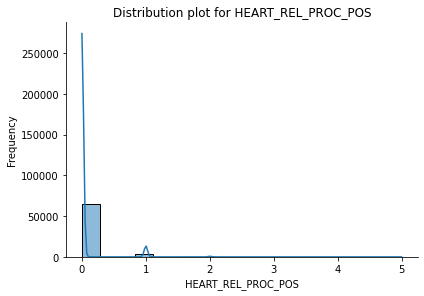

Text(0.5, 1.0, 'Distribution plot for LUNG_REL_PROC')

Text(0.5, 6.799999999999997, 'LUNG_REL_PROC')

Text(-15.074999999999996, 0.5, 'Frequency')

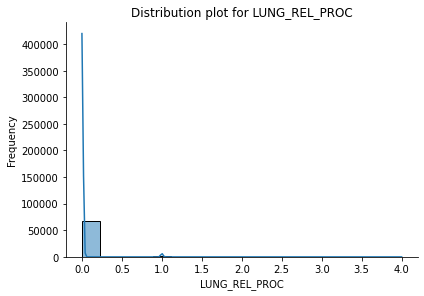

Text(0.5, 1.0, 'Distribution plot for OTHER_PROC_NEG')

Text(0.5, 6.799999999999997, 'OTHER_PROC_NEG')

Text(-15.199999999999996, 0.5, 'Frequency')

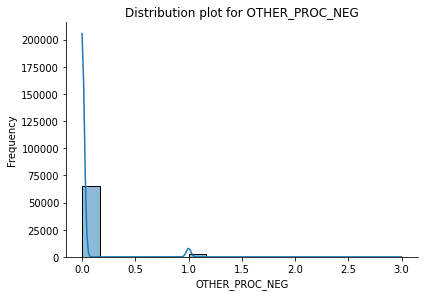

Text(0.5, 1.0, 'Distribution plot for OTHER_PROC_POS')

Text(0.5, 6.799999999999997, 'OTHER_PROC_POS')

Text(-15.074999999999996, 0.5, 'Frequency')

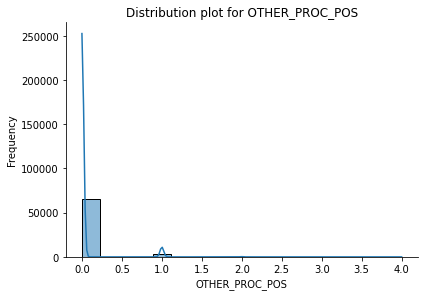

Text(0.5, 1.0, 'Distribution plot for SPINE_REL_PROC')

Text(0.5, 6.799999999999997, 'SPINE_REL_PROC')

Text(-15.074999999999996, 0.5, 'Frequency')

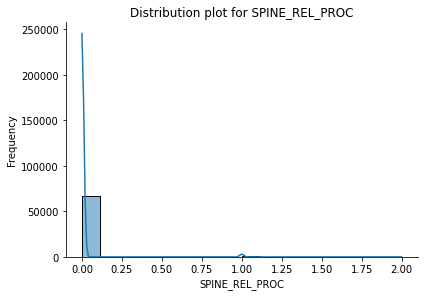

Text(0.5, 1.0, 'Distribution plot for SUB_REL_PROC')

Text(0.5, 6.799999999999997, 'SUB_REL_PROC')

Text(-14.949999999999996, 0.5, 'Frequency')

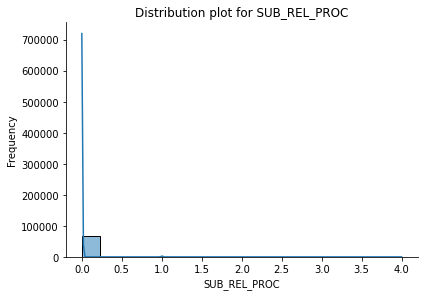

Text(0.5, 1.0, 'Distribution plot for URINARY_REL_PROC')

Text(0.5, 6.799999999999997, 'URINARY_REL_PROC')

Text(-15.074999999999996, 0.5, 'Frequency')

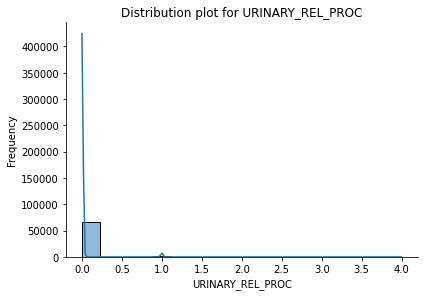

Text(0.5, 1.0, 'Distribution plot for PREV_3MON_OP_HARM')

Text(0.5, 6.799999999999997, 'PREV_3MON_OP_HARM')

Text(-15.074999999999996, 0.5, 'Frequency')

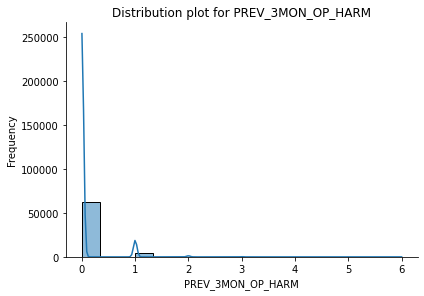

Text(0.5, 1.0, 'Distribution plot for OPIOID_HARM')

Text(0.5, 6.799999999999997, 'OPIOID_HARM')

Text(-15.074999999999996, 0.5, 'Frequency')

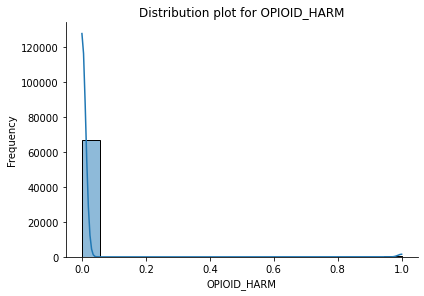

In [23]:
# Distribution plots

height = 4
aspect = 1.5

for col in num_cols:
    sns.displot(df[col], kde=True, height=height, aspect=aspect)
    plt.title(f'Distribution plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

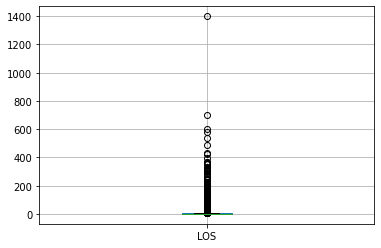

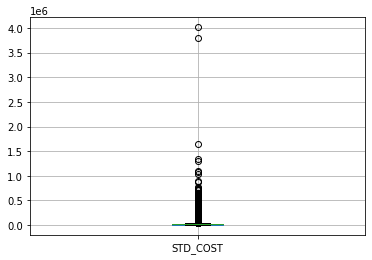

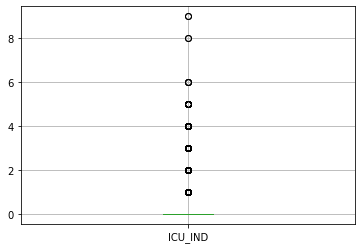

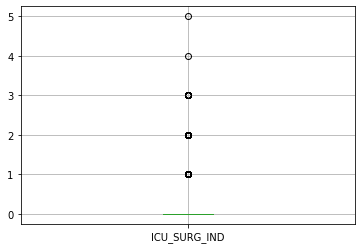

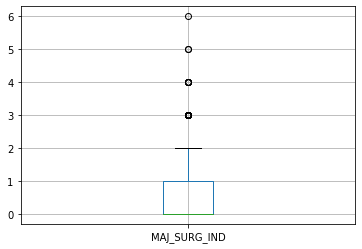

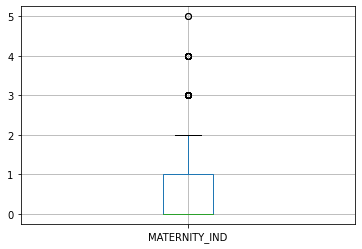

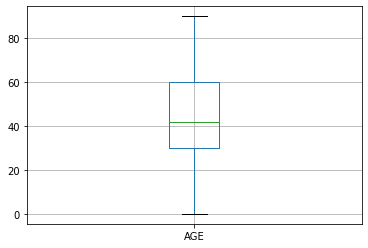

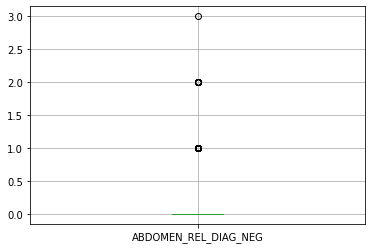

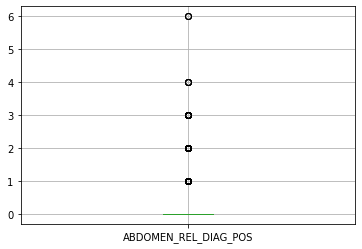

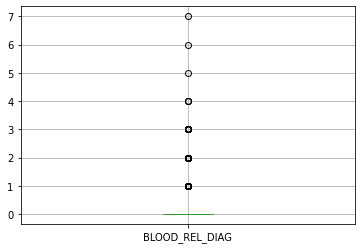

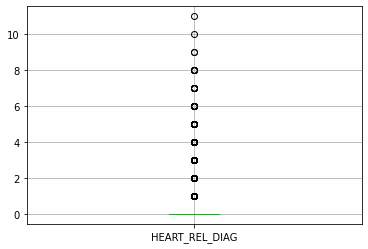

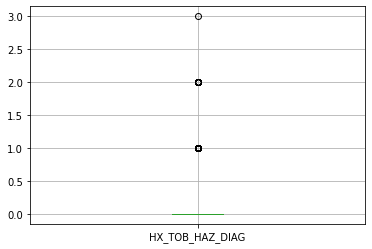

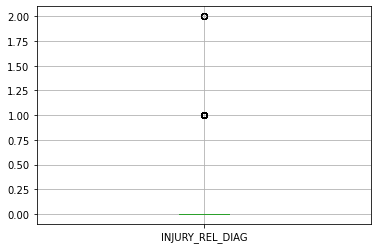

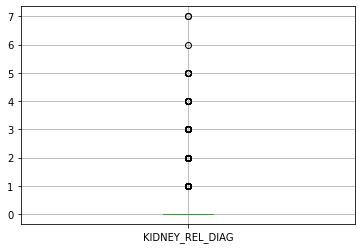

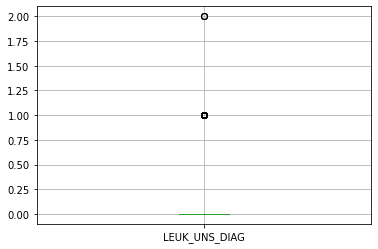

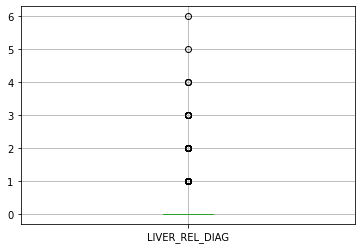

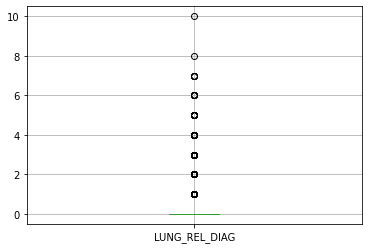

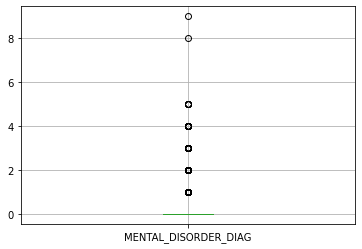

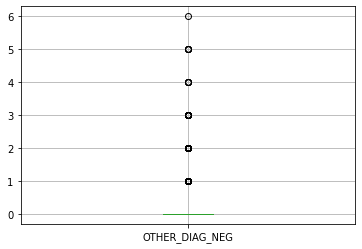

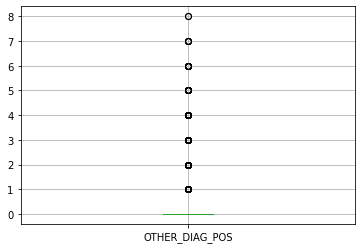

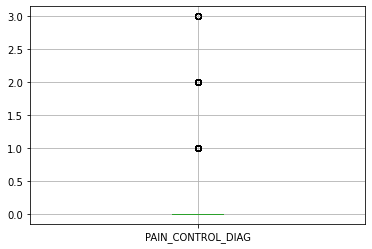

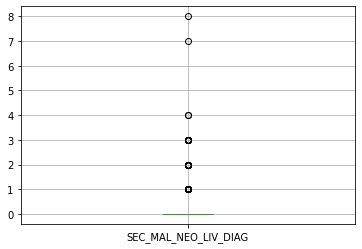

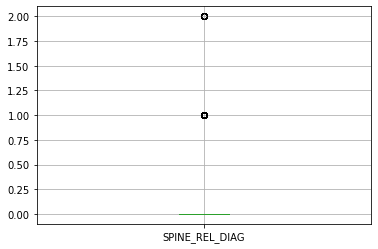

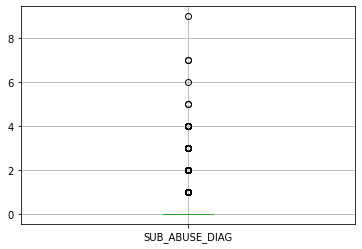

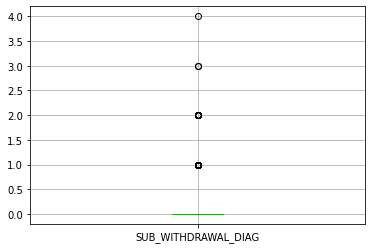

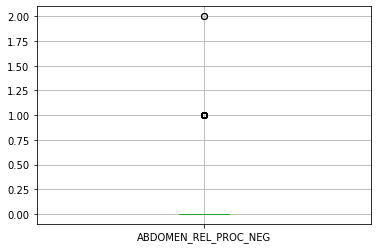

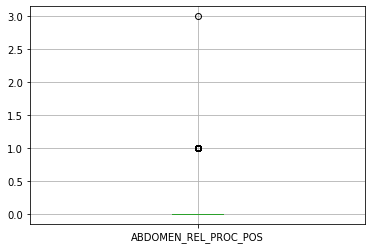

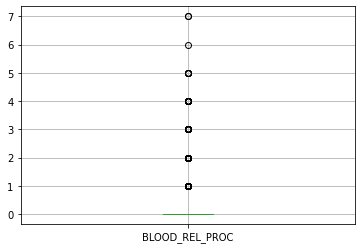

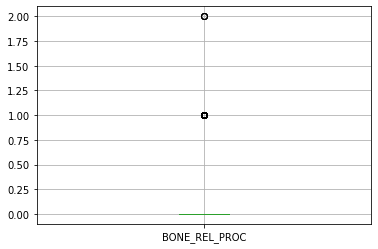

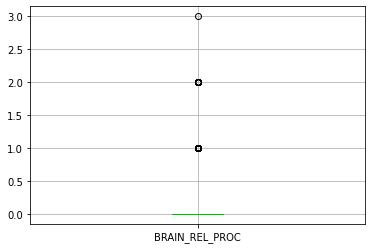

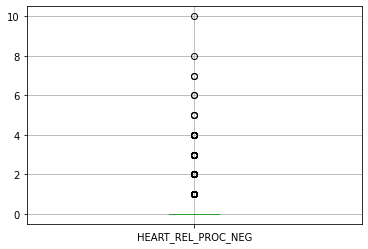

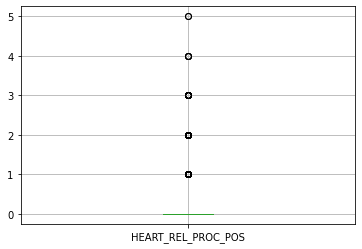

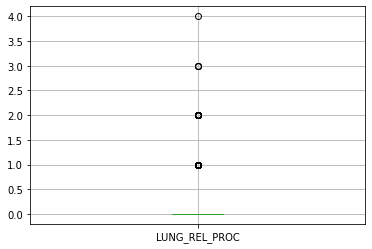

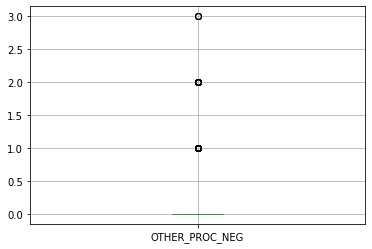

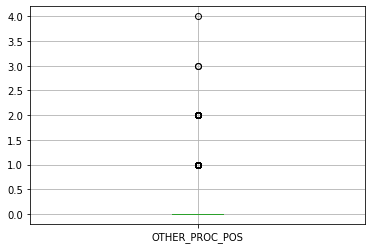

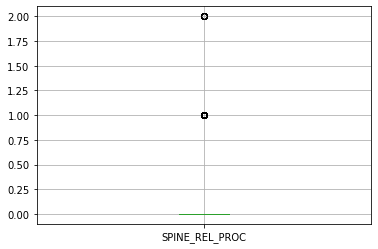

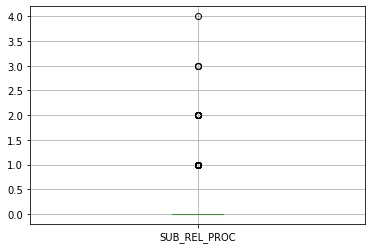

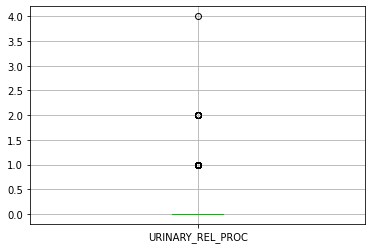

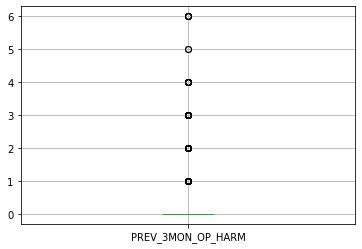

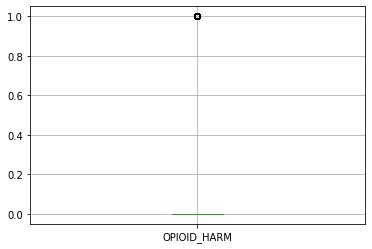

In [24]:
# Box plots

for col in num_cols:
    plt.figure()
    df.boxplot([col])

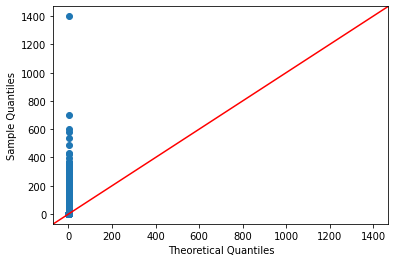

Text(0.5, 1.0, 'Q-Q plot for LOS')

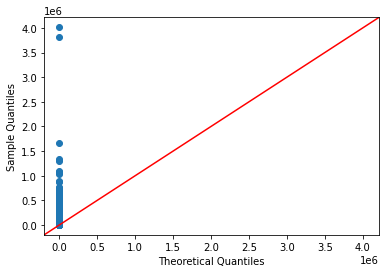

Text(0.5, 1.0, 'Q-Q plot for STD_COST')

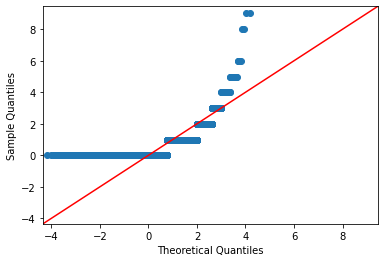

Text(0.5, 1.0, 'Q-Q plot for ICU_IND')

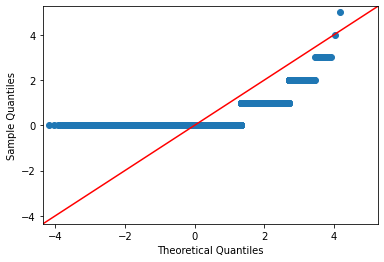

Text(0.5, 1.0, 'Q-Q plot for ICU_SURG_IND')

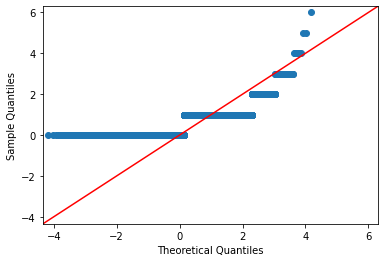

Text(0.5, 1.0, 'Q-Q plot for MAJ_SURG_IND')

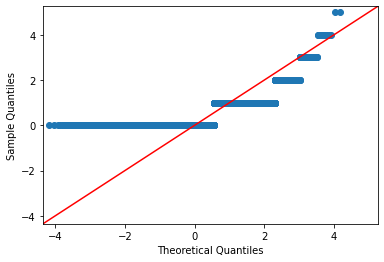

Text(0.5, 1.0, 'Q-Q plot for MATERNITY_IND')

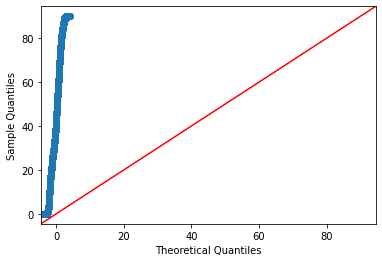

Text(0.5, 1.0, 'Q-Q plot for AGE')

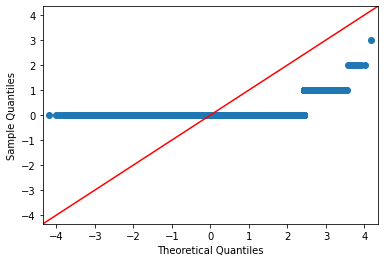

Text(0.5, 1.0, 'Q-Q plot for ABDOMEN_REL_DIAG_NEG')

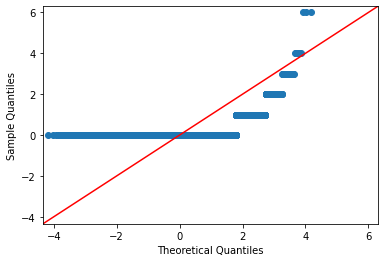

Text(0.5, 1.0, 'Q-Q plot for ABDOMEN_REL_DIAG_POS')

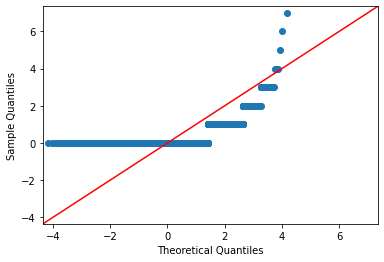

Text(0.5, 1.0, 'Q-Q plot for BLOOD_REL_DIAG')

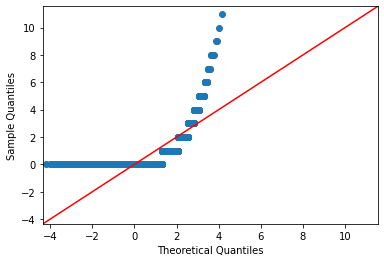

Text(0.5, 1.0, 'Q-Q plot for HEART_REL_DIAG')

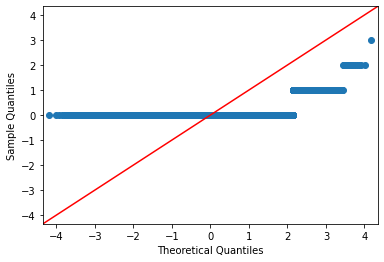

Text(0.5, 1.0, 'Q-Q plot for HX_TOB_HAZ_DIAG')

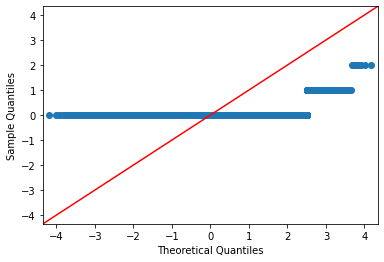

Text(0.5, 1.0, 'Q-Q plot for INJURY_REL_DIAG')

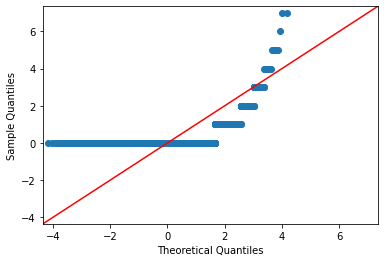

Text(0.5, 1.0, 'Q-Q plot for KIDNEY_REL_DIAG')

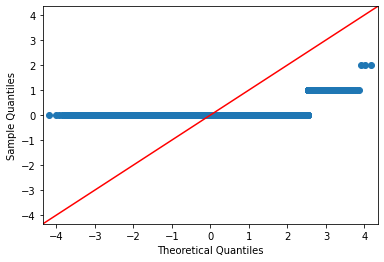

Text(0.5, 1.0, 'Q-Q plot for LEUK_UNS_DIAG')

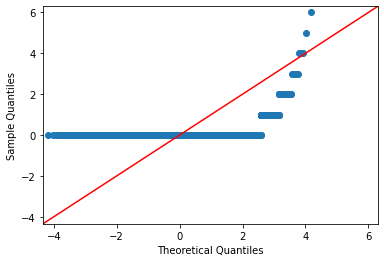

Text(0.5, 1.0, 'Q-Q plot for LIVER_REL_DIAG')

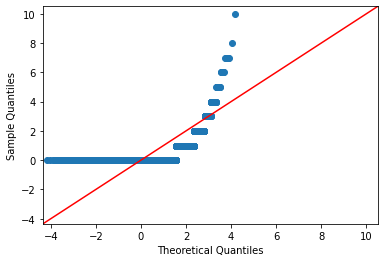

Text(0.5, 1.0, 'Q-Q plot for LUNG_REL_DIAG')

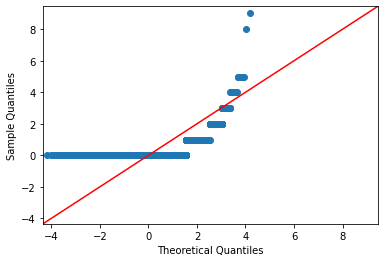

Text(0.5, 1.0, 'Q-Q plot for MENTAL_DISORDER_DIAG')

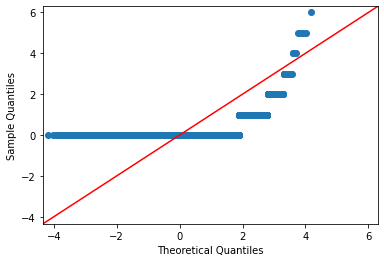

Text(0.5, 1.0, 'Q-Q plot for OTHER_DIAG_NEG')

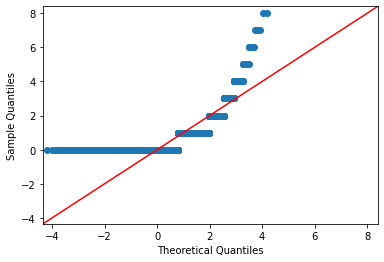

Text(0.5, 1.0, 'Q-Q plot for OTHER_DIAG_POS')

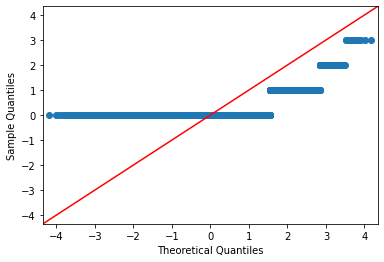

Text(0.5, 1.0, 'Q-Q plot for PAIN_CONTROL_DIAG')

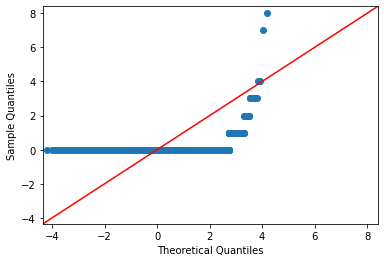

Text(0.5, 1.0, 'Q-Q plot for SEC_MAL_NEO_LIV_DIAG')

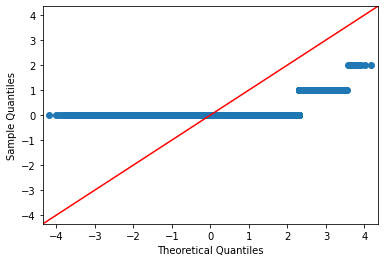

Text(0.5, 1.0, 'Q-Q plot for SPINE_REL_DIAG')

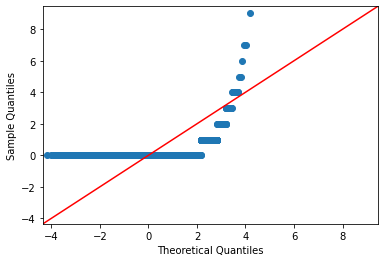

Text(0.5, 1.0, 'Q-Q plot for SUB_ABUSE_DIAG')

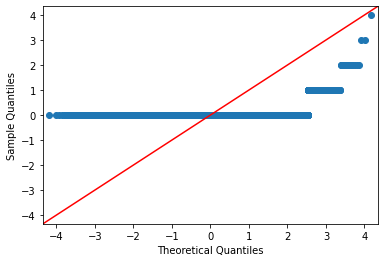

Text(0.5, 1.0, 'Q-Q plot for SUB_WITHDRAWAL_DIAG')

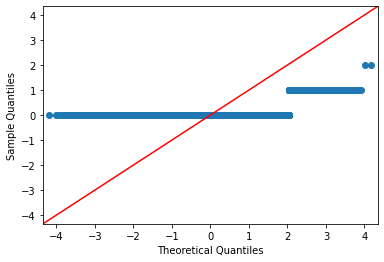

Text(0.5, 1.0, 'Q-Q plot for ABDOMEN_REL_PROC_NEG')

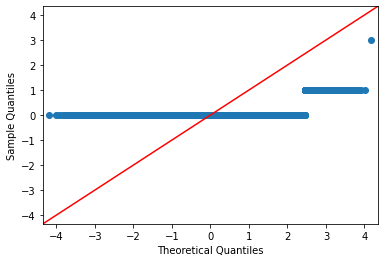

Text(0.5, 1.0, 'Q-Q plot for ABDOMEN_REL_PROC_POS')

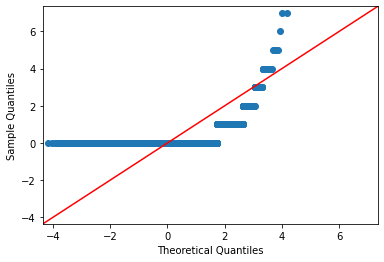

Text(0.5, 1.0, 'Q-Q plot for BLOOD_REL_PROC')

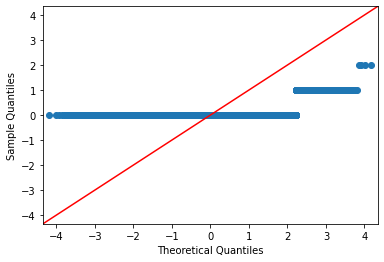

Text(0.5, 1.0, 'Q-Q plot for BONE_REL_PROC')

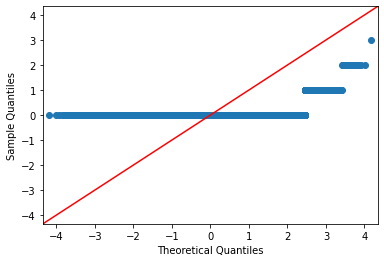

Text(0.5, 1.0, 'Q-Q plot for BRAIN_REL_PROC')

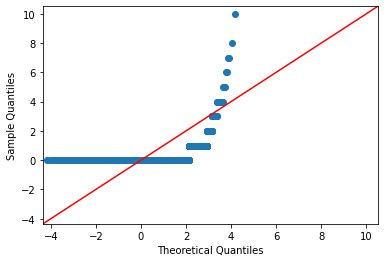

Text(0.5, 1.0, 'Q-Q plot for HEART_REL_PROC_NEG')

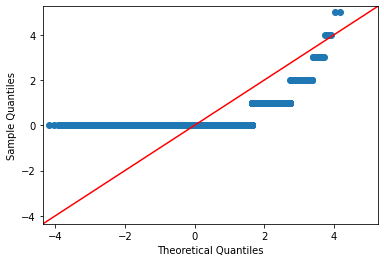

Text(0.5, 1.0, 'Q-Q plot for HEART_REL_PROC_POS')

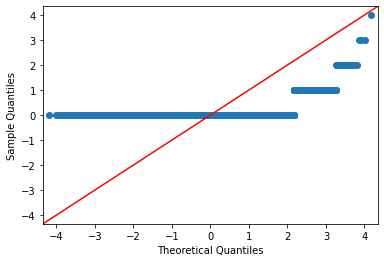

Text(0.5, 1.0, 'Q-Q plot for LUNG_REL_PROC')

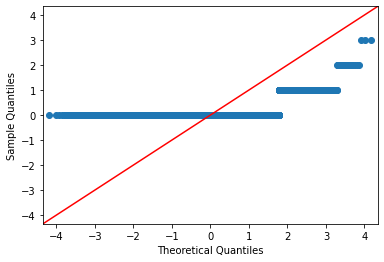

Text(0.5, 1.0, 'Q-Q plot for OTHER_PROC_NEG')

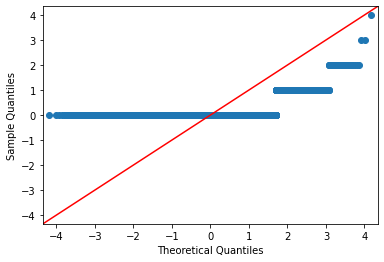

Text(0.5, 1.0, 'Q-Q plot for OTHER_PROC_POS')

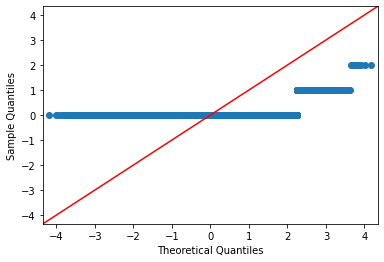

Text(0.5, 1.0, 'Q-Q plot for SPINE_REL_PROC')

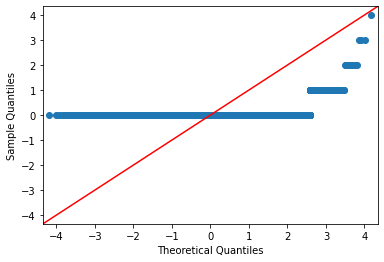

Text(0.5, 1.0, 'Q-Q plot for SUB_REL_PROC')

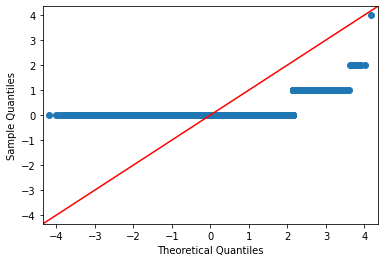

Text(0.5, 1.0, 'Q-Q plot for URINARY_REL_PROC')

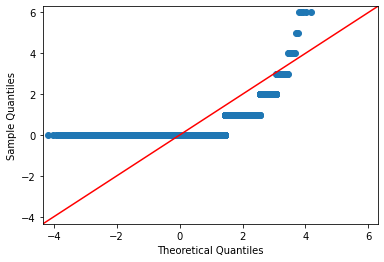

Text(0.5, 1.0, 'Q-Q plot for PREV_3MON_OP_HARM')

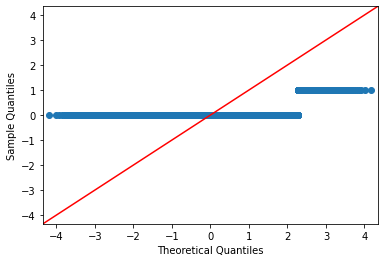

Text(0.5, 1.0, 'Q-Q plot for OPIOID_HARM')

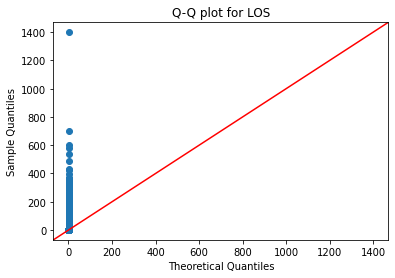

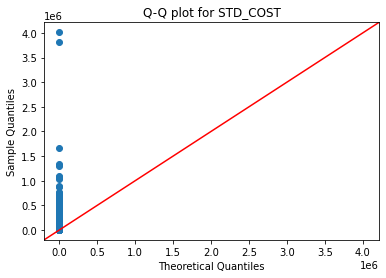

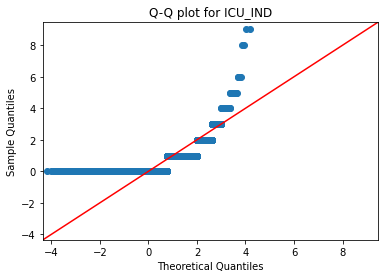

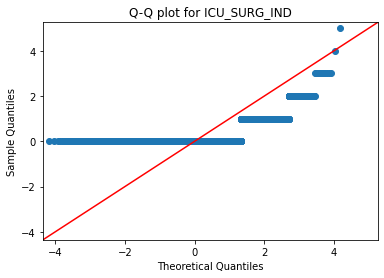

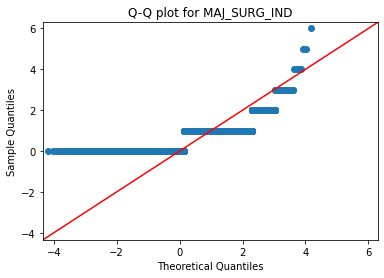

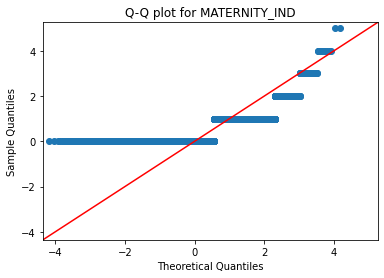

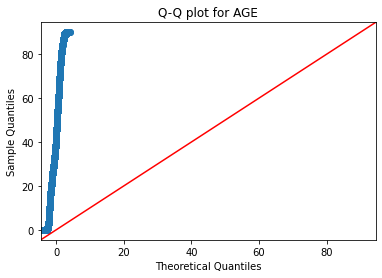

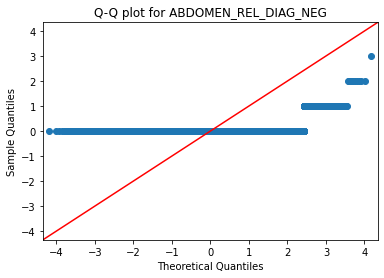

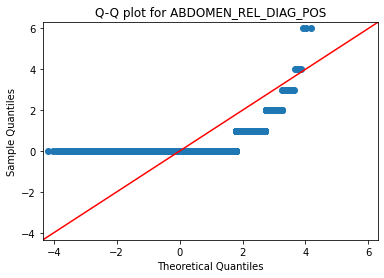

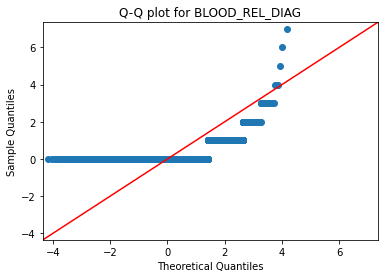

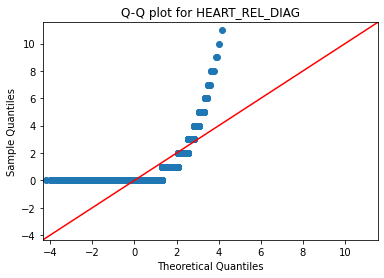

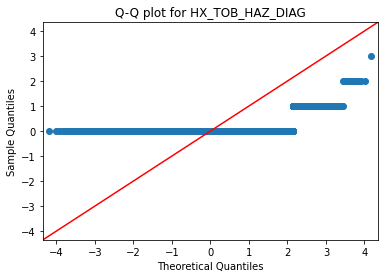

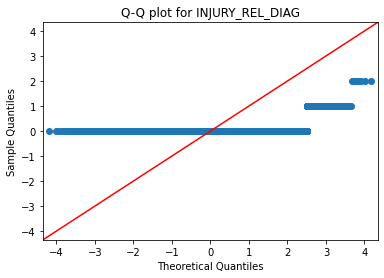

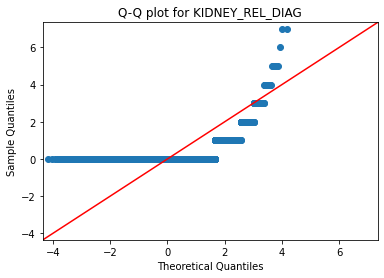

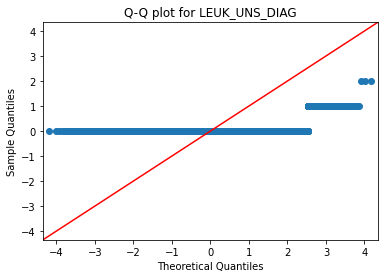

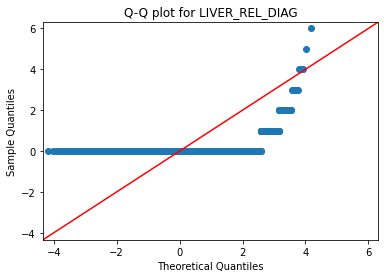

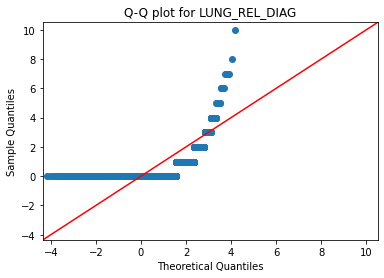

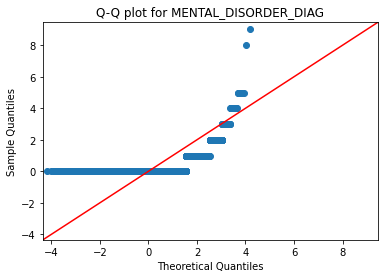

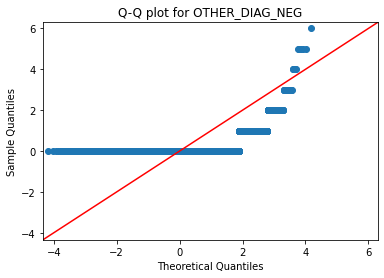

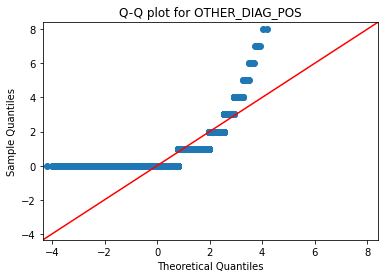

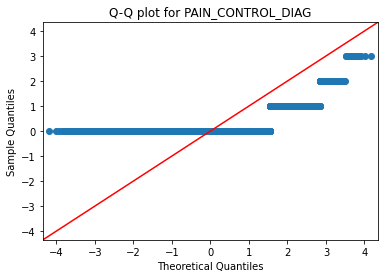

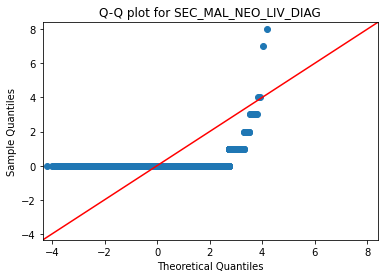

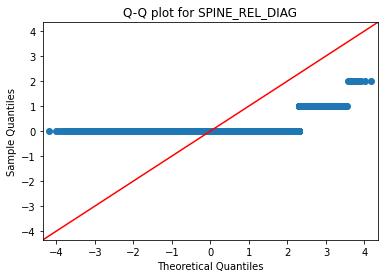

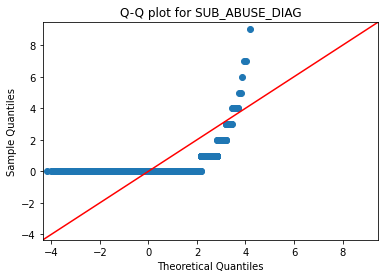

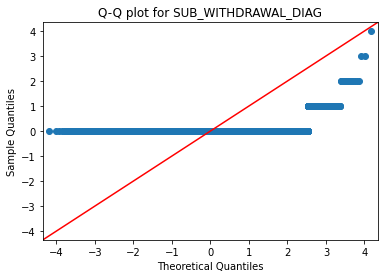

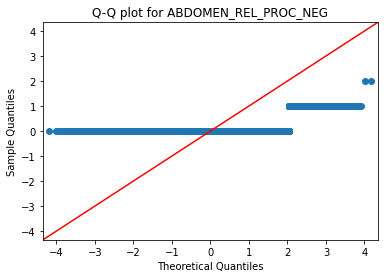

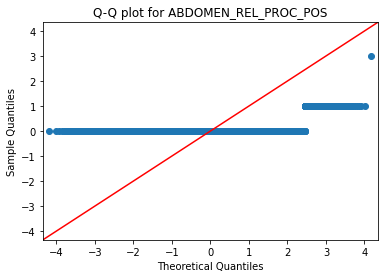

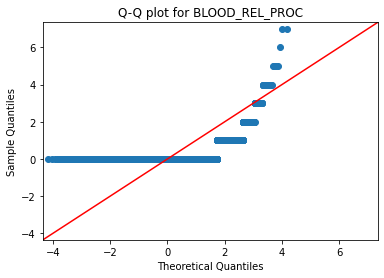

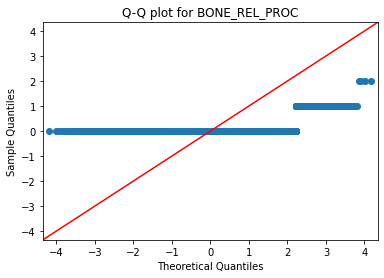

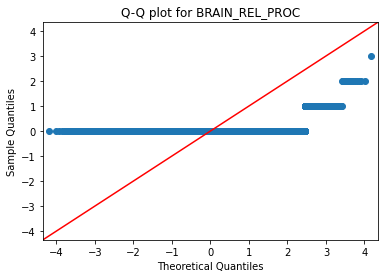

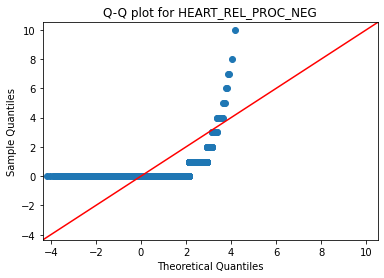

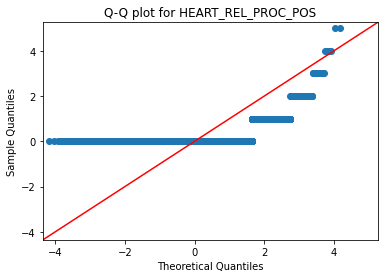

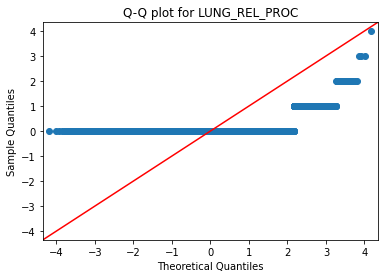

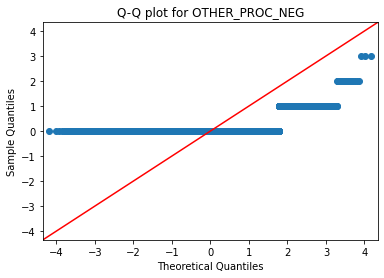

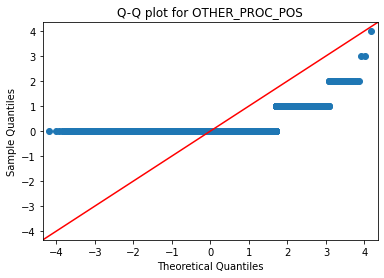

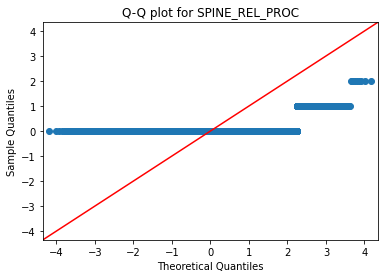

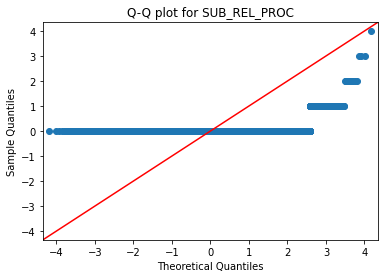

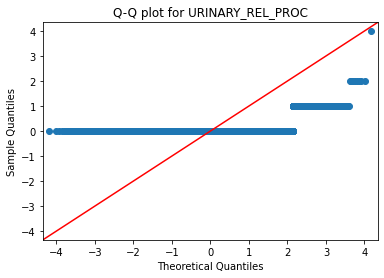

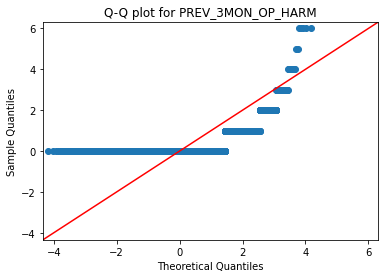

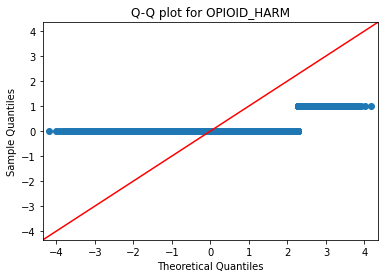

In [25]:
# create a Q-Q plot using statsmodels

# set the figure size for the plots
fig_width = 4
fig_height = 6

for col in num_cols:
    sm.qqplot(df[col], line='45')
    plt.title(f'Q-Q plot for {col}')

plt.show()

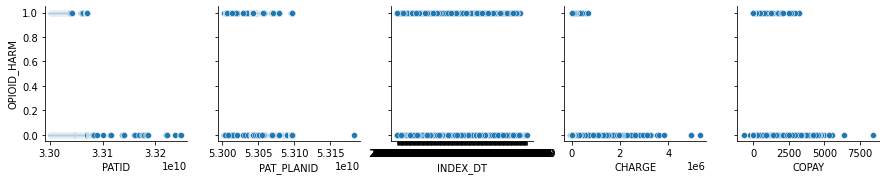

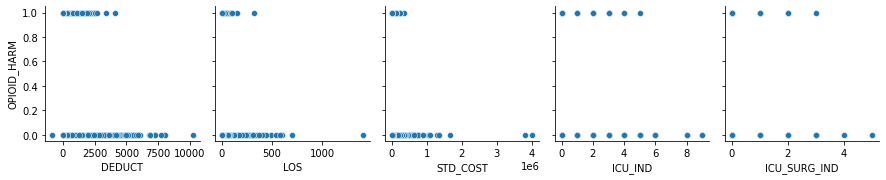

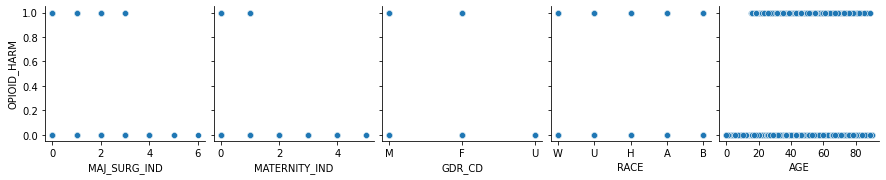

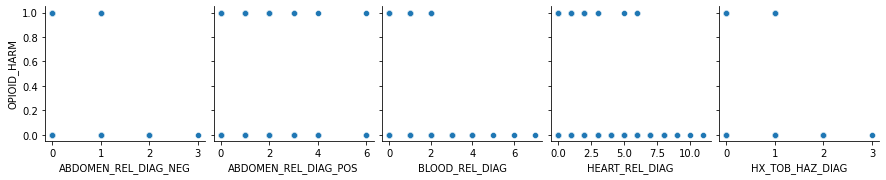

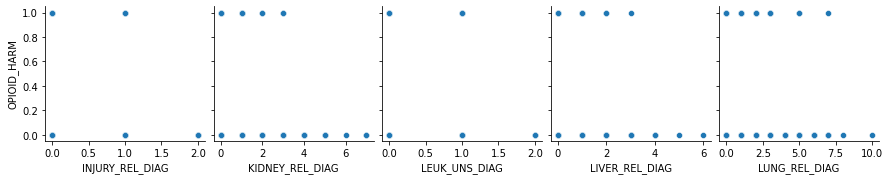

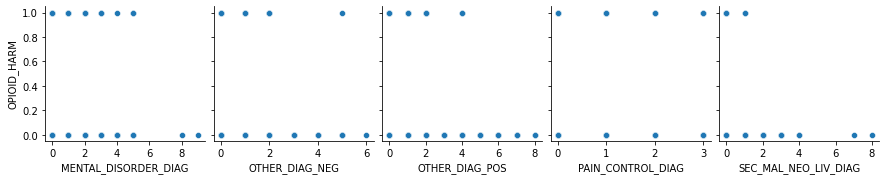

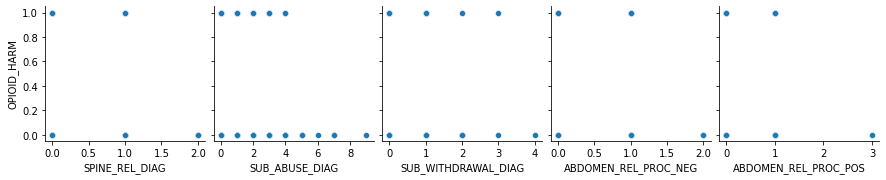

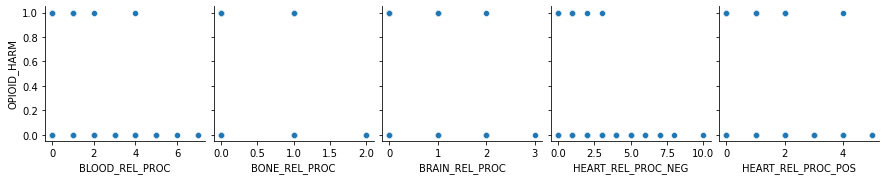

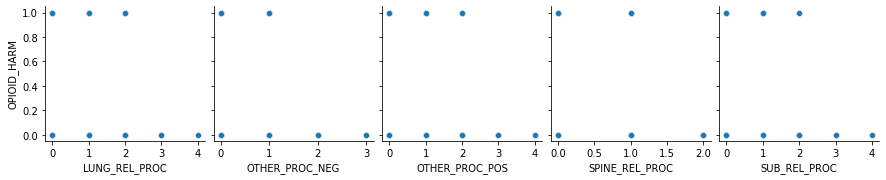

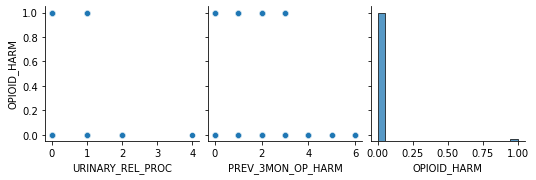

In [26]:
# Pair plots

for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=['OPIOID_HARM'])

In [27]:
num_cols

['LOS',
 'STD_COST',
 'ICU_IND',
 'ICU_SURG_IND',
 'MAJ_SURG_IND',
 'MATERNITY_IND',
 'AGE',
 'ABDOMEN_REL_DIAG_NEG',
 'ABDOMEN_REL_DIAG_POS',
 'BLOOD_REL_DIAG',
 'HEART_REL_DIAG',
 'HX_TOB_HAZ_DIAG',
 'INJURY_REL_DIAG',
 'KIDNEY_REL_DIAG',
 'LEUK_UNS_DIAG',
 'LIVER_REL_DIAG',
 'LUNG_REL_DIAG',
 'MENTAL_DISORDER_DIAG',
 'OTHER_DIAG_NEG',
 'OTHER_DIAG_POS',
 'PAIN_CONTROL_DIAG',
 'SEC_MAL_NEO_LIV_DIAG',
 'SPINE_REL_DIAG',
 'SUB_ABUSE_DIAG',
 'SUB_WITHDRAWAL_DIAG',
 'ABDOMEN_REL_PROC_NEG',
 'ABDOMEN_REL_PROC_POS',
 'BLOOD_REL_PROC',
 'BONE_REL_PROC',
 'BRAIN_REL_PROC',
 'HEART_REL_PROC_NEG',
 'HEART_REL_PROC_POS',
 'LUNG_REL_PROC',
 'OTHER_PROC_NEG',
 'OTHER_PROC_POS',
 'SPINE_REL_PROC',
 'SUB_REL_PROC',
 'URINARY_REL_PROC',
 'PREV_3MON_OP_HARM',
 'OPIOID_HARM']

In [28]:
# Scaling the variables based on above dsitributions

# We see there is no normal distribution except age. normalize using minmaxscaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
num_cols1 = num_cols.copy()
num_cols1.remove('LOS')
num_cols1.remove('STD_COST')
num_cols1.remove('AGE')

df[num_cols1] = scaler.fit_transform(df[num_cols1])

In [29]:
# standardscaler for age, LOS, STD_COST


cols_to_norm = ['LOS','STD_COST','AGE']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

In [30]:
df[num_cols].describe()

,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,HEART_REL_PROC_NEG,HEART_REL_PROC_POS,LUNG_REL_PROC,OTHER_PROC_NEG,OTHER_PROC_POS,SPINE_REL_PROC,SUB_REL_PROC,URINARY_REL_PROC,PREV_3MON_OP_HARM,OPIOID_HARM
count,6.795800e+04,6.795800e+04,67958.000000,67958.000000,67958.000000,67958.000000,6.795800e+04,67958.000000,67958.000000,67958.000000,...,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000,67958.000000
mean,2.488437e-17,-1.589254e-17,0.027355,0.019109,0.076393,0.059743,1.004785e-16,0.002531,0.006762,0.011646,...,0.001976,0.010627,0.003995,0.012881,0.011077,0.006239,0.001295,0.004135,0.013560,0.011728
std,1.000007e+00,1.000007e+00,0.056850,0.061552,0.087512,0.097481,1.000007e+00,0.029716,0.036856,0.042023,...,0.017781,0.048359,0.032700,0.065232,0.052838,0.056097,0.019280,0.032315,0.050863,0.107659
min,-3.332372e-01,-5.118451e-01,0.000000,0.000000,0.000000,0.000000,-2.238041e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.726296e-01,-3.134036e-01,0.000000,0.000000,0.000000,0.000000,-7.482759e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.120221e-01,-2.157747e-01,0.000000,0.000000,0.000000,0.000000,-1.523700e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-9.080698e-02,-2.440810e-02,0.000000,0.000000,0.166667,0.200000,7.414889e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.439612e+01,9.461703e+01,1.000000,1.000000,1.000000,1.000000,2.231254e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Categorical plots

In [31]:
cat_cols

['GDR_CD', 'RACE']

[Text(0, 0, '43997'), Text(0, 0, '23158'), Text(0, 0, '6')]

[Text(0, 0, '341'), Text(0, 0, '456'), Text(0, 0, '')]

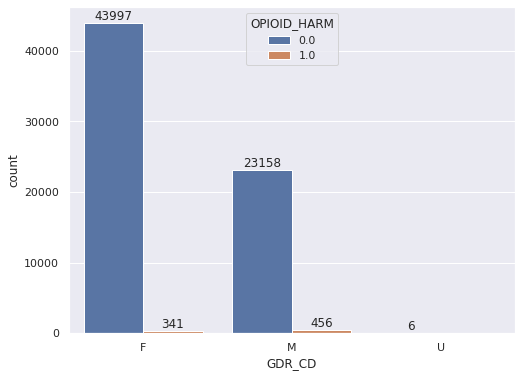

In [32]:
sns.set(rc={'figure.figsize':(8,6)})
ax=sns.countplot(x = 'GDR_CD',
              hue = 'OPIOID_HARM',
              data = df,
              order = df['GDR_CD'].value_counts().index)

for label in ax.containers:
    ax.bar_label(label)
    
plt.show()

[Text(0, 0, '42520'),
 Text(0, 0, '9593'),
 Text(0, 0, '6557'),
 Text(0, 0, '6510'),
 Text(0, 0, '1981')]

[Text(0, 0, '538'),
 Text(0, 0, '125'),
 Text(0, 0, '44'),
 Text(0, 0, '80'),
 Text(0, 0, '10')]

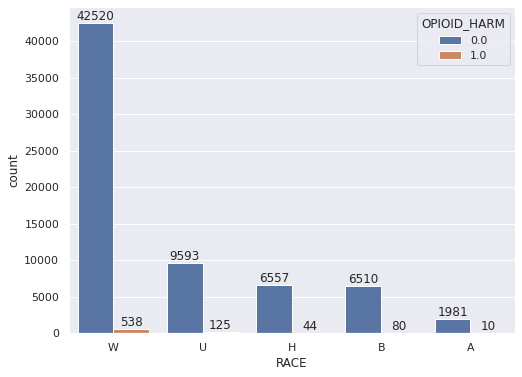

In [33]:
sns.set(rc={'figure.figsize':(8,6)})
ax=sns.countplot(x = 'RACE',
              hue = 'OPIOID_HARM',
              data = df,
              order = df['RACE'].value_counts().index)
for label in ax.containers:
    ax.bar_label(label)
    
plt.show()

# Checking for correlation

In [34]:
num_cols
cat_cols

['LOS',
 'STD_COST',
 'ICU_IND',
 'ICU_SURG_IND',
 'MAJ_SURG_IND',
 'MATERNITY_IND',
 'AGE',
 'ABDOMEN_REL_DIAG_NEG',
 'ABDOMEN_REL_DIAG_POS',
 'BLOOD_REL_DIAG',
 'HEART_REL_DIAG',
 'HX_TOB_HAZ_DIAG',
 'INJURY_REL_DIAG',
 'KIDNEY_REL_DIAG',
 'LEUK_UNS_DIAG',
 'LIVER_REL_DIAG',
 'LUNG_REL_DIAG',
 'MENTAL_DISORDER_DIAG',
 'OTHER_DIAG_NEG',
 'OTHER_DIAG_POS',
 'PAIN_CONTROL_DIAG',
 'SEC_MAL_NEO_LIV_DIAG',
 'SPINE_REL_DIAG',
 'SUB_ABUSE_DIAG',
 'SUB_WITHDRAWAL_DIAG',
 'ABDOMEN_REL_PROC_NEG',
 'ABDOMEN_REL_PROC_POS',
 'BLOOD_REL_PROC',
 'BONE_REL_PROC',
 'BRAIN_REL_PROC',
 'HEART_REL_PROC_NEG',
 'HEART_REL_PROC_POS',
 'LUNG_REL_PROC',
 'OTHER_PROC_NEG',
 'OTHER_PROC_POS',
 'SPINE_REL_PROC',
 'SUB_REL_PROC',
 'URINARY_REL_PROC',
 'PREV_3MON_OP_HARM',
 'OPIOID_HARM']

['GDR_CD', 'RACE']

In [35]:
X_variables = df[num_cols + cat_cols]
X_variables.shape
X_variables.head()

(67958, 42)

,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,LUNG_REL_PROC,OTHER_PROC_NEG,OTHER_PROC_POS,SPINE_REL_PROC,SUB_REL_PROC,URINARY_REL_PROC,PREV_3MON_OP_HARM,OPIOID_HARM,GDR_CD,RACE
0,-0.212022,0.152456,0.111111,0.0,0.000000,0.0,-0.152370,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,M,W
1,1.242559,0.507599,0.111111,0.0,0.000000,0.0,0.493195,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,W
2,-0.212022,-0.024408,0.000000,0.0,0.166667,0.2,-0.202029,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,W
3,-0.272630,-0.139985,0.000000,0.0,0.166667,0.0,-0.648958,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,U
4,-0.212022,-0.187830,0.000000,0.0,0.000000,0.0,0.393877,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,M,W


In [36]:
X_encoded = pd.get_dummies(X_variables, columns = ['GDR_CD', 'RACE'], dtype = float)
X_encoded.head()

,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,PREV_3MON_OP_HARM,OPIOID_HARM,GDR_CD_F,GDR_CD_M,GDR_CD_U,RACE_A,RACE_B,RACE_H,RACE_U,RACE_W
0,-0.212022,0.152456,0.111111,0.0,0.000000,0.0,-0.152370,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.242559,0.507599,0.111111,0.0,0.000000,0.0,0.493195,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.212022,-0.024408,0.000000,0.0,0.166667,0.2,-0.202029,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.272630,-0.139985,0.000000,0.0,0.166667,0.0,-0.648958,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.212022,-0.187830,0.000000,0.0,0.000000,0.0,0.393877,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


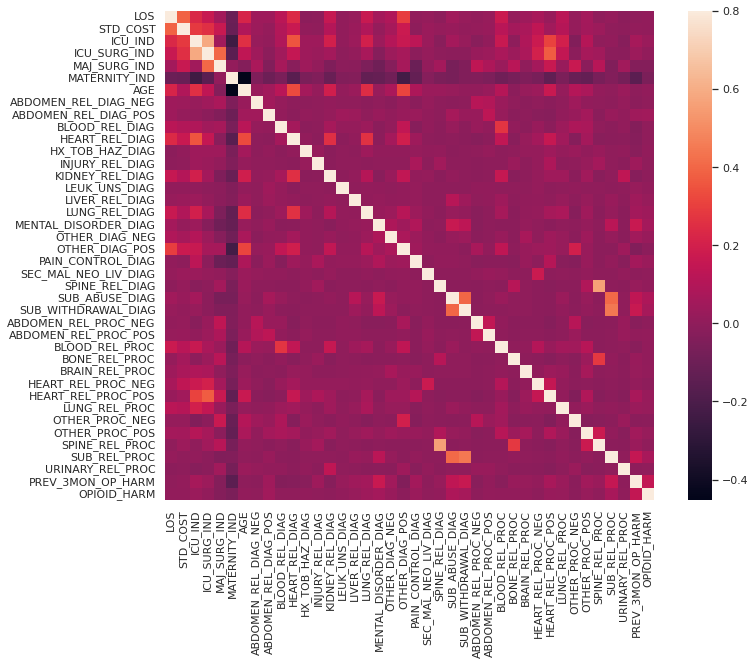

In [37]:
#correlation matrix
corrmat = X_variables.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [38]:
# Calculate VIF for each variable

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Variable'] = num_cols
vif['VIF'] = [variance_inflation_factor(X_variables[num_cols].values, i) for i in range(X_variables[num_cols].shape[1])]

vif.sort_values(by = 'VIF', ascending = False)


,Variable,VIF
2,ICU_IND,2.395969
3,ICU_SURG_IND,2.280307
4,MAJ_SURG_IND,2.014576
35,SPINE_REL_PROC,1.626341
6,AGE,1.534510
22,SPINE_REL_DIAG,1.471870
5,MATERNITY_IND,1.468434
19,OTHER_DIAG_POS,1.467654
10,HEART_REL_DIAG,1.441219
36,SUB_REL_PROC,1.364950


# Random undersampling

## Splitting the dataset

In [39]:
X_encoded.head()

,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,PREV_3MON_OP_HARM,OPIOID_HARM,GDR_CD_F,GDR_CD_M,GDR_CD_U,RACE_A,RACE_B,RACE_H,RACE_U,RACE_W
0,-0.212022,0.152456,0.111111,0.0,0.000000,0.0,-0.152370,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.242559,0.507599,0.111111,0.0,0.000000,0.0,0.493195,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.212022,-0.024408,0.000000,0.0,0.166667,0.2,-0.202029,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.272630,-0.139985,0.000000,0.0,0.166667,0.0,-0.648958,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.212022,-0.187830,0.000000,0.0,0.000000,0.0,0.393877,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
print('Non Opioid Harm', round(X_encoded['OPIOID_HARM'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Opioid Harm', round(X_encoded['OPIOID_HARM'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Non Opioid Harm 98.83 % of the dataset
Opioid Harm 1.17 % of the dataset


In [41]:
X = X_encoded.drop('OPIOID_HARM', axis=1)
X.shape
y = X_encoded['OPIOID_HARM']
y.shape

(67958, 47)

(67958,)

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

In [43]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Train: [12632 12660 12686 ... 67955 67956 67957] Test: [    0     1     2 ... 13607 13608 13609]
Train: [    0     1     2 ... 67955 67956 67957] Test: [12632 12660 12686 ... 27212 27213 27214]
Train: [    0     1     2 ... 67955 67956 67957] Test: [25147 25235 25438 ... 40803 40804 40805]
Train: [    0     1     2 ... 67955 67956 67957] Test: [38554 38615 38704 ... 54401 54402 54403]
Train: [    0     1     2 ... 54401 54402 54403] Test: [51365 51424 51502 ... 67955 67956 67957]


In [44]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98826494 0.01173506]
[0.98830108 0.01169892]


In [45]:
X_encoded['OPIOID_HARM'].value_counts()

0.0    67161
1.0      797
Name: OPIOID_HARM, dtype: int64

In [46]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

X_encoded = X_encoded.sample(frac=1)

# amount of non-op harm classes 797 rows.
op_df = X_encoded.loc[X_encoded['OPIOID_HARM'] == 1]
non_op_df = X_encoded.loc[X_encoded['OPIOID_HARM'] == 0][:797]

normal_distributed_df = pd.concat([op_df, non_op_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,LOS,STD_COST,ICU_IND,ICU_SURG_IND,MAJ_SURG_IND,MATERNITY_IND,AGE,ABDOMEN_REL_DIAG_NEG,ABDOMEN_REL_DIAG_POS,BLOOD_REL_DIAG,...,PREV_3MON_OP_HARM,OPIOID_HARM,GDR_CD_F,GDR_CD_M,GDR_CD_U,RACE_A,RACE_B,RACE_H,RACE_U,RACE_W
33251,-0.212022,-0.024408,0.000000,0.0,0.166667,0.2,-0.499982,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15550,-0.151415,-0.024408,0.000000,0.0,0.166667,0.2,-0.599299,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11611,-0.212022,-0.287582,0.000000,0.0,0.000000,0.2,-0.698617,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26704,0.272838,0.170142,0.111111,0.2,0.166667,0.0,-0.351005,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
17767,-0.151415,-0.215421,0.111111,0.0,0.000000,0.0,0.294559,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Distribution of the Classes in the subsample dataset
0.0    0.5
1.0    0.5
Name: OPIOID_HARM, dtype: float64


<AxesSubplot:xlabel='OPIOID_HARM', ylabel='count'>

Text(0.5, 1.0, 'Equally Distributed Classes')

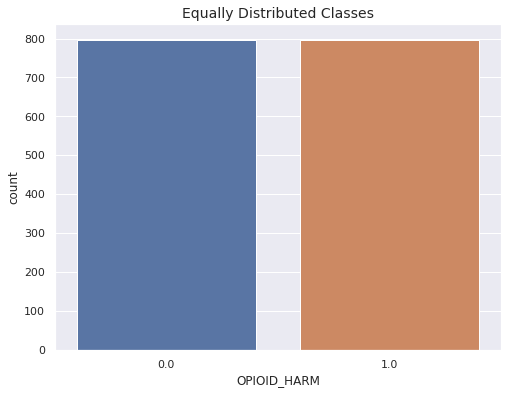

In [47]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['OPIOID_HARM'].value_counts()/len(new_df))

sns.countplot('OPIOID_HARM', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, "Imbalanced Correlation Matrix \n (don't use for reference)")

<AxesSubplot:>

Text(0.5, 1.0, 'SubSample Correlation Matrix \n (use for reference)')

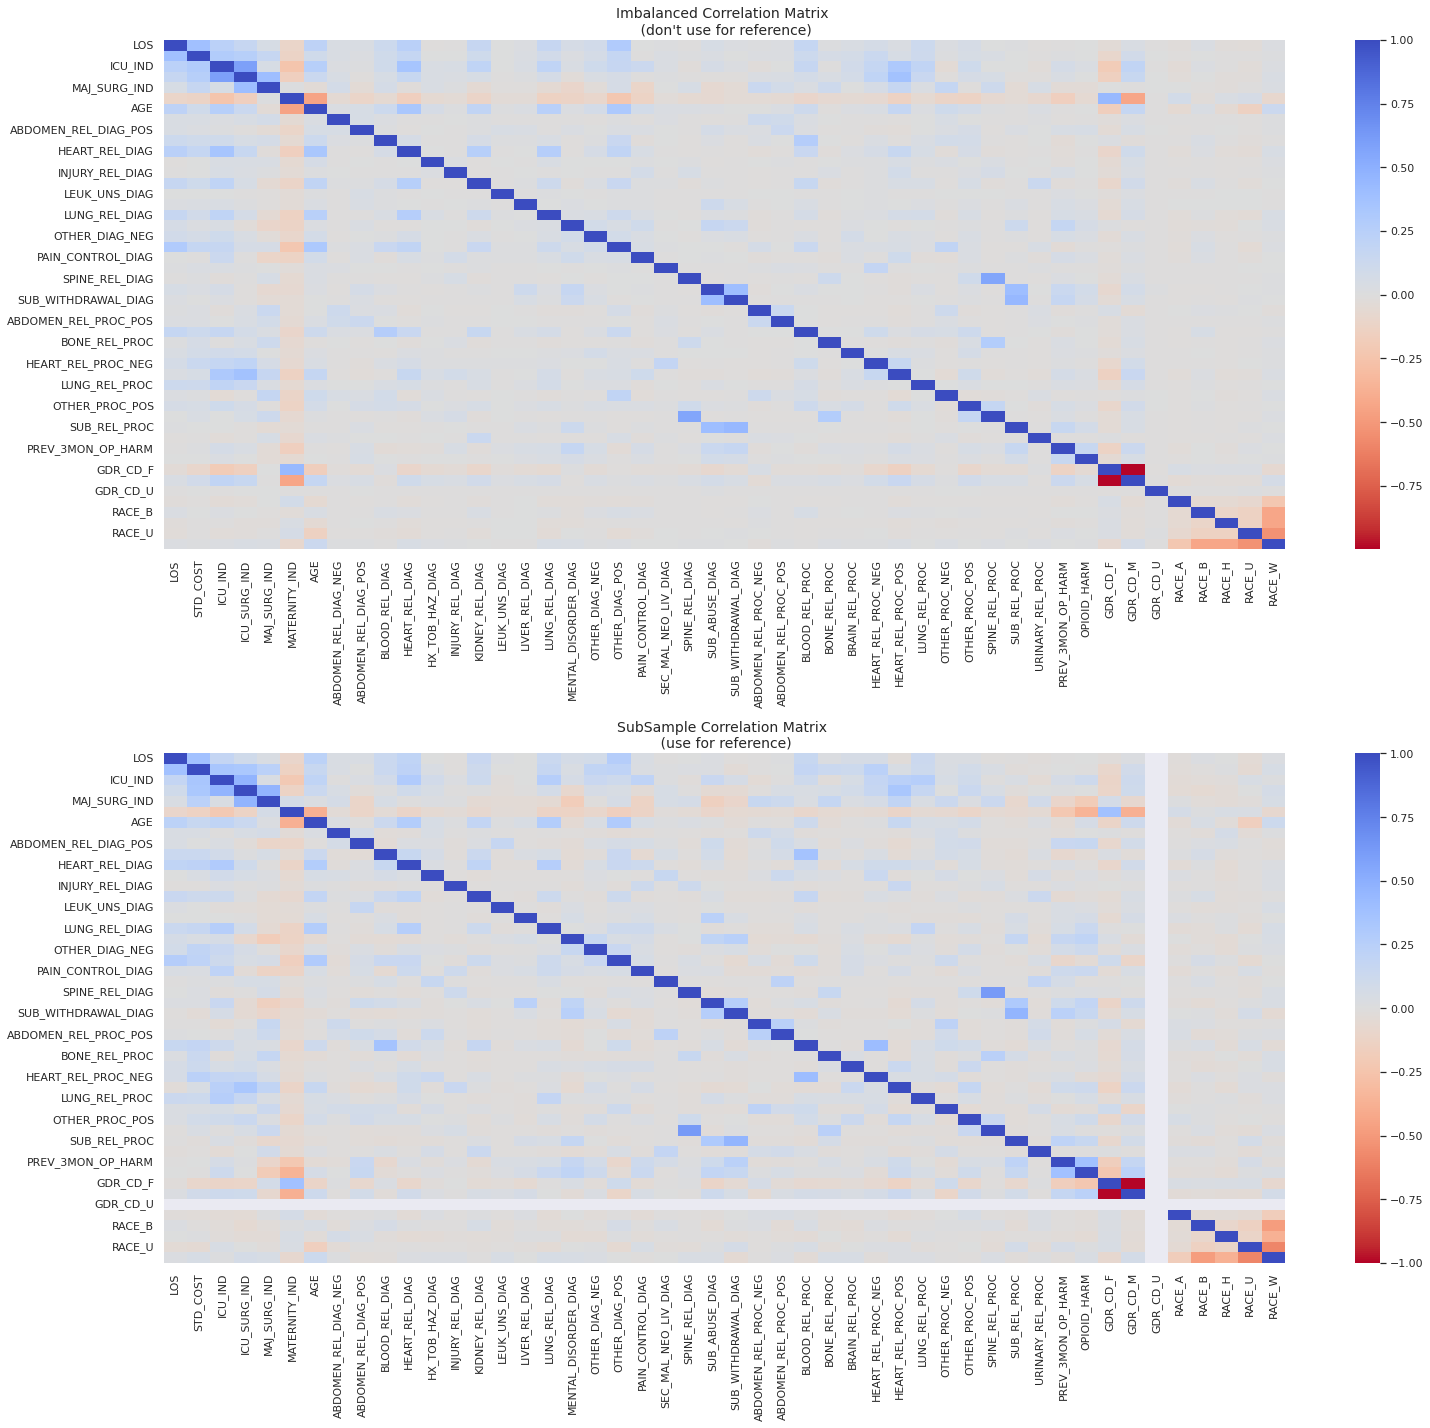

In [48]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(22,20))

# Entire DataFrame
corr = X_encoded.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

# adjust subplot spacing
plt.tight_layout()
plt.show()

In [49]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

In [50]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('OPIOID_HARM', axis=1)
y = new_df['OPIOID_HARM']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.4 s
PCA took 0.01 s
Truncated SVD took 0.0062 s


Text(0.5, 0.98, 'Clusters using Dimensionality Reduction')

Text(0.5, 1.0, 't-SNE')

Text(0.5, 1.0, 'PCA')

Text(0.5, 1.0, 'Truncated SVD')

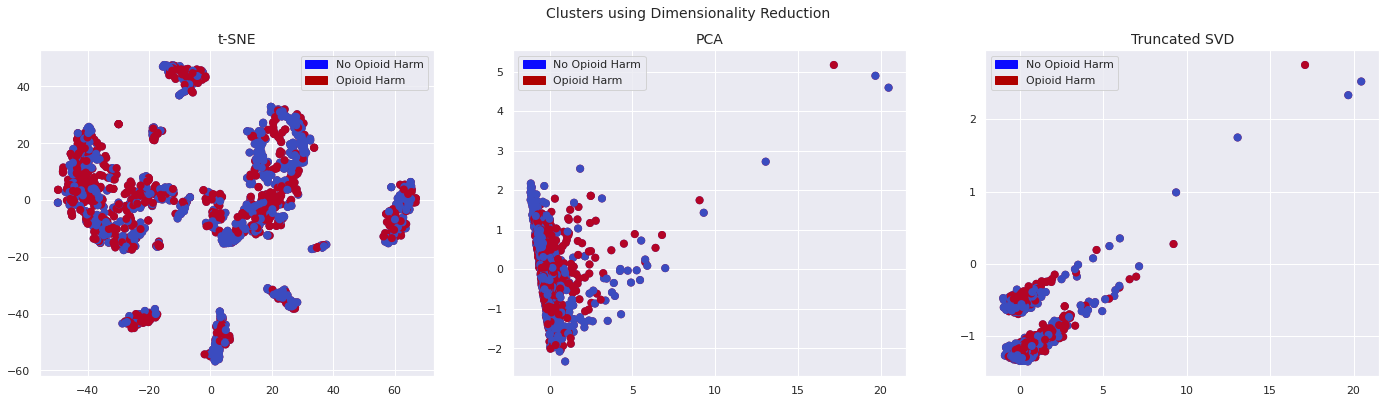

In [51]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Opioid Harm', 'Opioid Harm']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Opioid Harm')
red_patch = mpatches.Patch(color='#AF0000', label='Opioid Harm')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Opioid Harm', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Opioid Harm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Opioid Harm', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Opioid Harm', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Opioid Harm', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Opioid Harm', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [52]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('OPIOID_HARM', axis=1)
y = new_df['OPIOID_HARM']

In [53]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  

In [56]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "RandomForest Classifier": RandomForestClassifier(),
    "XGBoost Classifier": XGBClassifier(),
}

In [57]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
    

LogisticRegression()

Classifiers:  LogisticRegression Has a training score of 72.0 % accuracy score


RandomForestClassifier()

Classifiers:  RandomForestClassifier Has a training score of 73.0 % accuracy score


XGBClassifier()

Classifiers:  XGBClassifier Has a training score of 75.0 % accuracy score


In [58]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [59]:
log_reg

LogisticRegression(C=10)

In [60]:
# Random Forest 

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_
rf = CV_rfc.best_estimator_

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

In [61]:
# XGB

# dset inmbalanced => scale_pos_weight helps with imbalanced data
# use gridsearch() 
# for precision
# r1
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0.0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight': [1,2]
}
# {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}
# # r2
param_grid = {
    'gamma':[1.2,1.0,0.8],
    'learning_rate':[0.075,0.1,0.125],
    'max_depth':[2,3,4],
    'reg_lambda':[0.5,1,1.5],
    'scale_pos_weight': [1,2]

}
# {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1, 'scale_pos_weight': 1}
# # # r3
param_grid = { 
    'gamma':[0.9,1,1.1],
    'learning_rate':[1.1,1.0,0.9],
    'max_depth':[2,3],
    'reg_lambda':[0.75,1,1.25],
    'scale_pos_weight': [1]
}
# {'gamma': 1.1, 'learning_rate': 0.9, 'max_depth': 3, 'reg_lambda': 1, 'scale_pos_weight': 1
# # r4
param_grid = { 
    'gamma':[1.05,1.1,1.15],
    'learning_rate':[0.85,0.9,0.95],
    'max_depth':[3],
    'reg_lambda':[0.9,1,1.1],
    'scale_pos_weight': [110/92,1,1.2]
}
optimal_params = GridSearchCV(
    estimator = XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample = 0.6,
                            colsample_bytree=0.5,
                            eval_metric= 'auc',
                            early_stopping_rounds = 10),
    param_grid=param_grid,
    scoring = 'precision',
    verbose=0,
    n_jobs = -1,
    cv = 3
)
optimal_params.fit(X_train,y_train, eval_set = [(X_test,y_test)],verbose = False)
print(optimal_params.best_params_)


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     eval_metric='auc', seed=42,
                                     subsample=0.6),
             n_jobs=-1,
             param_grid={'gamma': [1.05, 1.1, 1.15],
                         'learning_rate': [0.85, 0.9, 0.95], 'max_depth': [3],
                         'reg_lambda': [0.9, 1, 1.1],
                         'scale_pos_weight': [1.1956521739130435, 1, 1.2]},
             scoring='precision')

{'gamma': 1.05, 'learning_rate': 0.95, 'max_depth': 3, 'reg_lambda': 1, 'scale_pos_weight': 1}


In [62]:
xgb = XGBClassifier(objective='binary:logistic', seed=42,
                    gamma = 1.05, learning_rate = 0.9, max_depth = 3, reg_lambda= 1, scale_pos_weight =1)
                    
xgb.fit(X_train,y_train,
        early_stopping_rounds=10,
        eval_metric = 'auc',
        eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.76142
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.82716
[2]	validation_0-auc:0.818757
[3]	validation_0-auc:0.836982
[4]	validation_0-auc:0.838994
[5]	validation_0-auc:0.836608
[6]	validation_0-auc:0.843294
[7]	validation_0-auc:0.833945
[8]	validation_0-auc:0.830217
[9]	validation_0-auc:0.831696
[10]	validation_0-auc:0.829112
[11]	validation_0-auc:0.825247
[12]	validation_0-auc:0.827791
[13]	validation_0-auc:0.828245
[14]	validation_0-auc:0.822643
[15]	validation_0-auc:0.827219
[16]	validation_0-auc:0.826647
Stopping. Best iteration:
[6]	validation_0-auc:0.843294



XGBClassifier(gamma=1.05, learning_rate=0.9, seed=42)

In [63]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

rf_score = cross_val_score(rf, X_train, y_train, cv=5)
print('Random Forest Cross Validation Score', round(rf_score.mean() * 100, 2).astype(str) + '%')

xgb_score = cross_val_score(xgb, X_train, y_train, cv=5)
print('XGBoost Classifier Cross Validation Score', round(xgb_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  73.96%
Random Forest Cross Validation Score 76.0%
XGBoost Classifier Cross Validation Score 72.39%


In [64]:
# We will undersample during cross validating
undersample_X = X_encoded.drop('OPIOID_HARM', axis=1)
undersample_y = X_encoded['OPIOID_HARM']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

Train: [13584 13585 13586 ... 67955 67956 67957] Test: [    0     1     2 ... 13927 13971 13983]
Train: [    0     1     2 ... 67955 67956 67957] Test: [13584 13585 13586 ... 27181 27182 27243]
Train: [    0     1     2 ... 67955 67956 67957] Test: [27183 27184 27185 ... 40773 40774 40775]
Train: [    0     1     2 ... 67955 67956 67957] Test: [40776 40777 40778 ... 54382 54383 54384]
Train: [    0     1     2 ... 54382 54383 54384] Test: [52961 53031 53104 ... 67955 67956 67957]


In [65]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

In [66]:
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

NearMiss Label Distribution: Counter({0.0: 797, 1.0: 797})


In [67]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

rf_pred = cross_val_predict(rf, X_train, y_train, cv=5)

xgb_pred = cross_val_predict(xgb, X_train, y_train, cv=5)


In [68]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('Random Forest: ', roc_auc_score(y_train, rf_pred))
print('XGBoost: ', roc_auc_score(y_train, xgb_pred))


Logistic Regression:  0.8098856554996603
Random Forest:  0.759338790498036
XGBoost:  0.7237199618031286


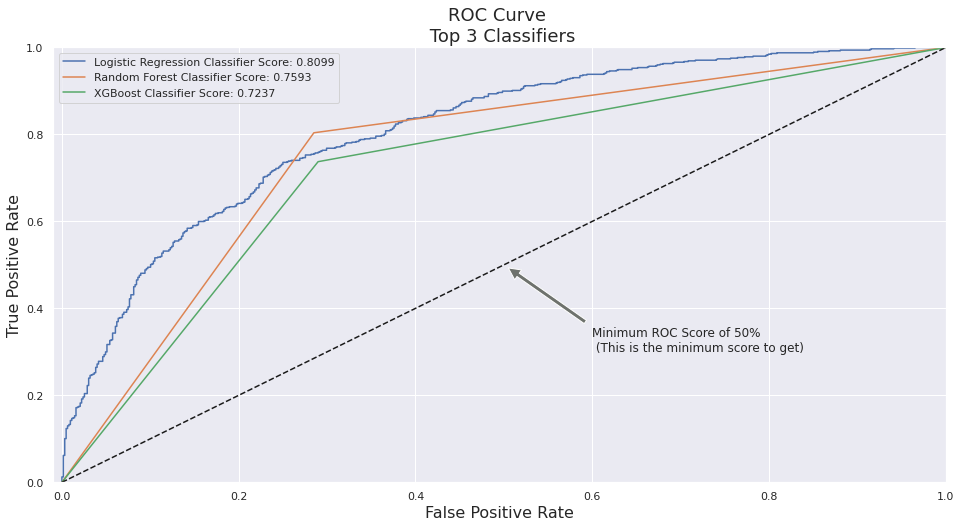

In [69]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_train, xgb_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train, xgb_pred)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr)
plt.show()

In [70]:
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.98
Precision Score: 0.56
F1 Score: 0.71
Accuracy Score: 0.59
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.26
Precision Score: 0.01
Recall Score: 0.78
F1 Score: 0.02
---------------------------------------------------------------------------------------------------------------------------------------


In [71]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [72]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.01


# SMOTE

In [73]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

Length of X (train): 54367 | Length of y (train): 54367
Length of X (test): 13591 | Length of y (test): 13591


In [74]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.7535820988458027
precision: 0.03172598449809717
recall: 0.667802657480315
f1: 0.06055016218778818
---------------------------------------------------------------------------------------------------------------------------------------


In [75]:
best_est

LogisticRegression(C=0.001)

In [76]:
labels = ['No Opioid Harm', 'Opioid Harm']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

                precision    recall  f1-score   support

No Opioid Harm       0.99      0.65      0.78     13432
   Opioid Harm       0.02      0.55      0.04       159

      accuracy                           0.65     13591
     macro avg       0.50      0.60      0.41     13591
  weighted avg       0.98      0.65      0.78     13591



In [77]:
y_score = best_est.decision_function(original_Xtest)

In [78]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.05


In [79]:
type(original_ytrain[0])

numpy.float64

In [80]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [81]:
Counter(ysm_train)

Counter({0.0: 53729, 1.0: 53729})

In [82]:
y_test.shape

(319,)

In [83]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

LogisticRegression(C=10)

Fitting oversample data took :1.9802286624908447 sec


In [84]:
X_test.shape

(319, 47)

In [85]:
original_Xtest.shape
original_ytest.shape

(13591, 47)

(13591,)

In [86]:
df['OPIOID_HARM'].value_counts()

0.0    67161
1.0      797
Name: OPIOID_HARM, dtype: int64

In [103]:
X_test.shape

(319, 47)

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79       169
         1.0       0.76      0.77      0.76       150

    accuracy                           0.77       319
   macro avg       0.77      0.77      0.77       319
weighted avg       0.77      0.77      0.77       319
 
confusion_matrix:
 [[132  37]
 [ 35 115]]


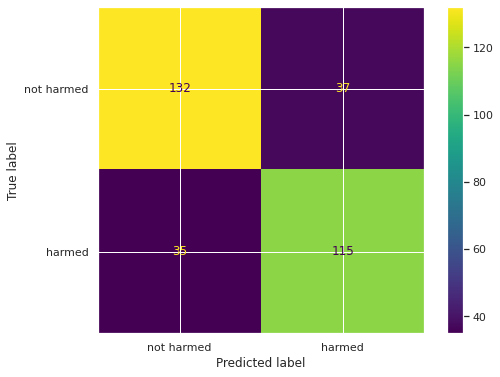

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(log_reg_sm, X_test, y_test, values_format = 'd', display_labels=['not harmed', 'harmed'])
print(classification_report(y_test,log_reg_sm.predict(X_test)),'\nconfusion_matrix:\n',confusion_matrix(y_test,log_reg_sm.predict(X_test)))


In [105]:
# Model coefficients
lrCoeff = pd.concat([pd.DataFrame(X.columns),
                       pd.DataFrame(np.transpose(log_reg_sm.coef_))], axis = 1)
lrCoeff.columns=['Variable','Coefficient']
lrCoeff['Coefficient_Abs']=lrCoeff['Coefficient'].apply(abs)
lrCoeff.sort_values(by='Coefficient_Abs', ascending=False)

,Variable,Coefficient,Coefficient_Abs
23,SUB_ABUSE_DIAG,11.772923,11.772923
38,PREV_3MON_OP_HARM,11.117128,11.117128
16,LUNG_REL_DIAG,8.792113,8.792113
5,MATERNITY_IND,-8.325584,8.325584
30,HEART_REL_PROC_NEG,-6.961402,6.961402
4,MAJ_SURG_IND,-5.096825,5.096825
13,KIDNEY_REL_DIAG,-4.698003,4.698003
8,ABDOMEN_REL_DIAG_POS,4.563673,4.563673
15,LIVER_REL_DIAG,3.953138,3.953138
17,MENTAL_DISORDER_DIAG,3.843793,3.843793


<BarContainer object of 47 artists>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

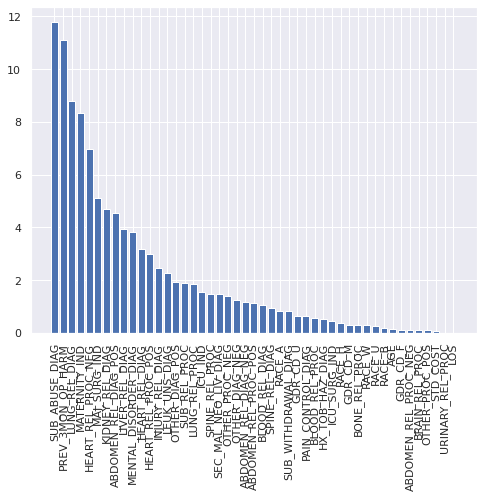

In [106]:
# plt.bar(lassoCoeff.sort_values(by='Coefficient_Abs', ascending=False))
lfbar = lrCoeff.sort_values(by='Coefficient_Abs', ascending=False).reset_index(drop=True)
plt.bar(lfbar.Variable, lfbar.Coefficient_Abs)
plt.xticks(rotation='vertical')

In [90]:
rf_sm = CV_rfc.best_estimator_
rf_sm.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=7, n_estimators=200, random_state=42)

              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79       169
         1.0       0.88      0.50      0.64       150

    accuracy                           0.73       319
   macro avg       0.78      0.72      0.71       319
weighted avg       0.77      0.73      0.72       319
 
confusion_matrix:
 [[159  10]
 [ 75  75]]


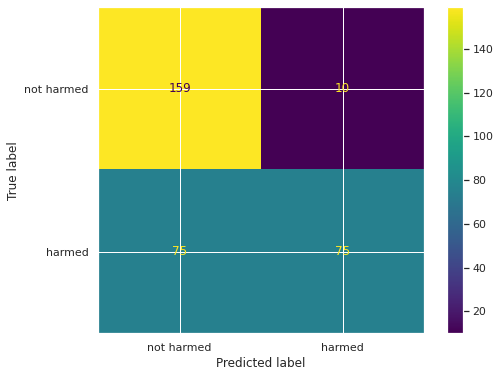

In [107]:
plot_confusion_matrix(rf_sm, X_test, y_test, values_format = 'd', display_labels=['not harmed', 'harmed'])
print(classification_report(y_test,rf_sm.predict(X_test)),'\nconfusion_matrix:\n',confusion_matrix(y_test,rf_sm.predict(X_test)))


In [92]:
from sklearn.inspection import permutation_importance
def plot_perm(clf):
    train_result = permutation_importance(
        clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
    )
    test_results = permutation_importance(
        clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_importances_idx = train_result.importances_mean.argsort()
    train_importances = pd.DataFrame(
        train_result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    test_importances = pd.DataFrame(
        test_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    for name, importances in zip(["train", "test"], [train_importances, test_importances]):
        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances ({name} set)")
        ax.set_xlabel("Decrease in accuracy score")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.figure.tight_layout()


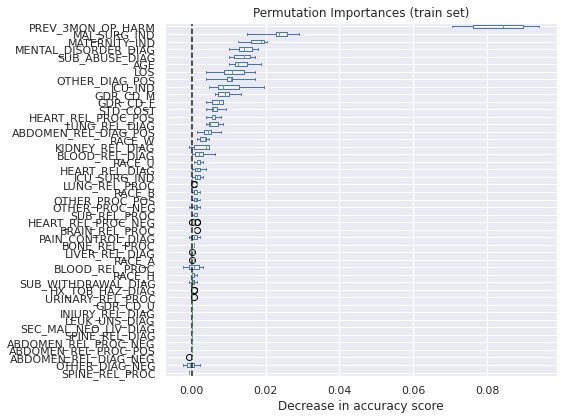

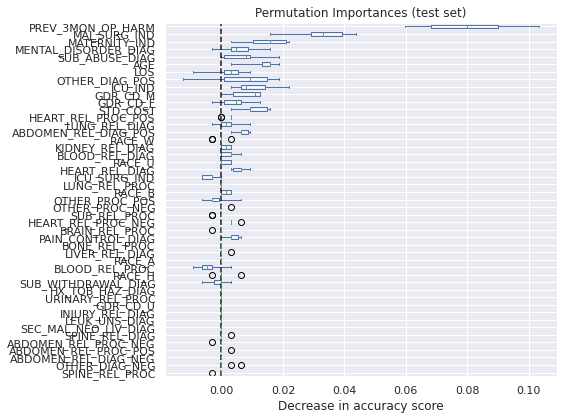

In [108]:
plot_perm(rf)

In [94]:
ysm_train.shape

(107458,)

In [97]:
xgb_sm = XGBClassifier(objective='binary:logistic', seed=42,
                    gamma = 1.05, learning_rate = 0.85, max_depth = 3, reg_lambda= 1, scale_pos_weight =1)
                    
xgb_sm.fit(Xsm_train, ysm_train,
        early_stopping_rounds=10,
        eval_metric = 'auc',
        eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.744813
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.791874
[2]	validation_0-auc:0.806963
[3]	validation_0-auc:0.80359
[4]	validation_0-auc:0.823866
[5]	validation_0-auc:0.828047
[6]	validation_0-auc:0.809211
[7]	validation_0-auc:0.797692
[8]	validation_0-auc:0.801341
[9]	validation_0-auc:0.796844
[10]	validation_0-auc:0.795385
[11]	validation_0-auc:0.799152
[12]	validation_0-auc:0.794497
[13]	validation_0-auc:0.794379
[14]	validation_0-auc:0.80215
[15]	validation_0-auc:0.795464
Stopping. Best iteration:
[5]	validation_0-auc:0.828047



XGBClassifier(gamma=1.05, learning_rate=0.85, seed=42)

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76       169
         1.0       0.91      0.33      0.48       150

    accuracy                           0.67       319
   macro avg       0.76      0.65      0.62       319
weighted avg       0.75      0.67      0.63       319
 
confusion_matrix:
 [[164   5]
 [101  49]]


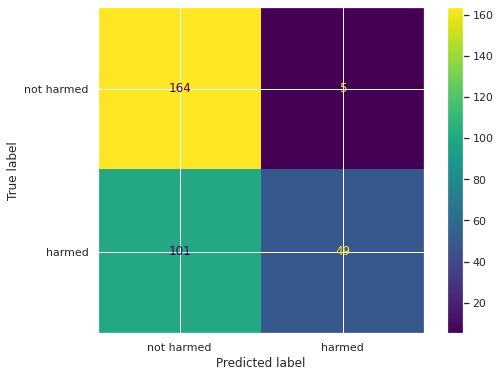

In [109]:
plot_confusion_matrix(xgb_sm, X_test, y_test, values_format = 'd', display_labels=['not harmed', 'harmed'])
print(classification_report(y_test,xgb_sm.predict(X_test)),'\nconfusion_matrix:\n',confusion_matrix(y_test,xgb_sm.predict(X_test)))


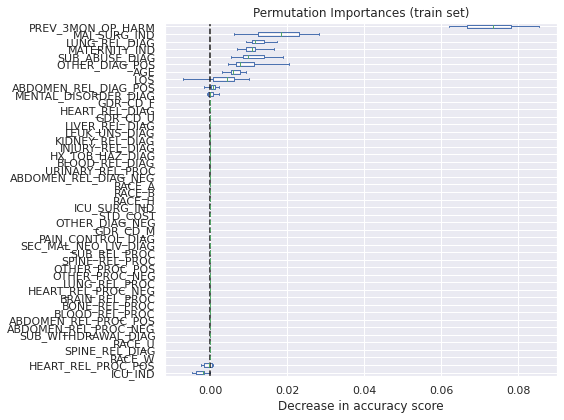

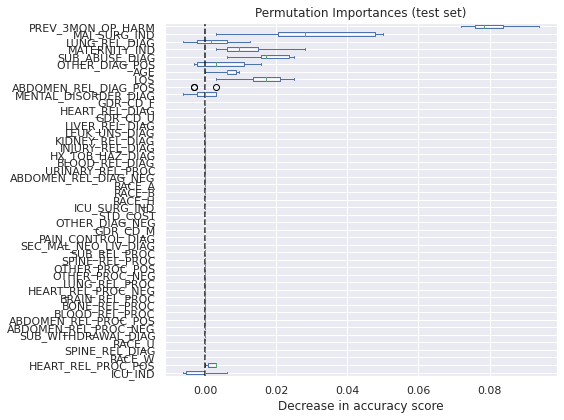

In [110]:
plot_perm(xgb)

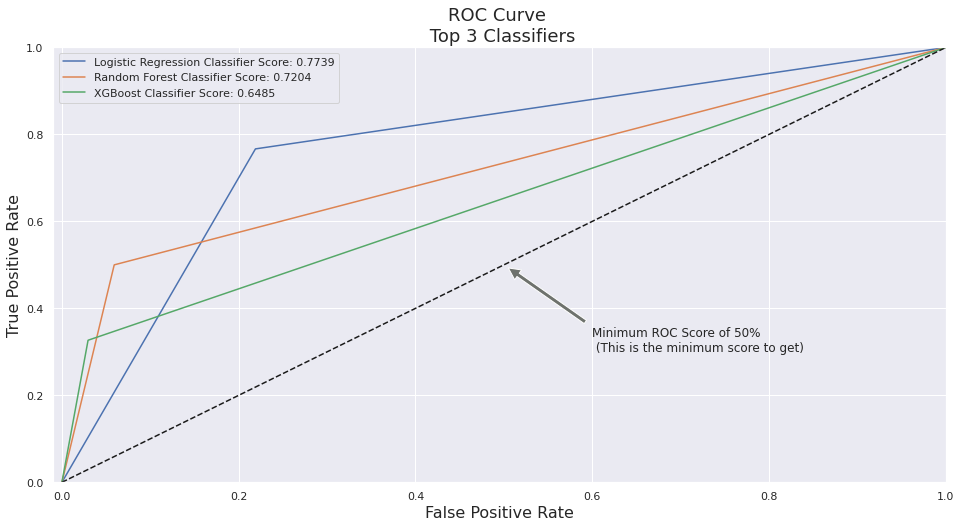

In [111]:
log_fpr, log_tpr, log_thresold = roc_curve(y_test, log_reg_sm.predict(X_test))
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_sm.predict(X_test))
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_sm.predict(X_test))


def graph_roc_curve_multiple(log_fpr, log_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, log_reg_sm.predict(X_test))))
    plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test, rf_sm.predict(X_test))))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_test, xgb_sm.predict(X_test))))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rf_fpr, rf_tpr, xgb_fpr, xgb_tpr)
plt.show()

In [112]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df


,Technique,Score
0,Random UnderSampling,0.774295
1,Oversampling (SMOTE),0.648297
